In [4]:
import pandas as pd
import numpy as np 
from gpxutils import parse_gpx 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [5]:
# read the four data files
rr_2016 = parse_gpx('files/Calga_RR_2016.gpx')
tt_2016 = parse_gpx('files/Calga_TT_2016.gpx')
rr_2019 = parse_gpx('files/Calga_RR_2019.gpx')
tt_2019 = parse_gpx('files/Calga_TT_2019.gpx')

In [3]:
rr_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.000000,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0


In [4]:
rides = [rr_2016, tt_2016, rr_2019, tt_2019]

The total time taken was:  0 days 01:26:40


## Summary for Each Ride
In order to provide a quick summary of each ride, I have set up a def that will print out the following:
* The overall distance (sums up distnace column and rounds the result to within the meter)
* The total time of each ride (taking away the first time index from the last)
* The average speed of each ride (finds the mean of the speed column)

In [32]:
def summary(dataframe):
    print("The overall distance was: ", round(dataframe["distance"].sum(), 2), "kms", sep = "")
    timeTaken = dataframe.index[len(dataframe.index) - 1] - dataframe.index[0]
    print("The total time taken was: ", timeTaken)
    print("The average speed of the ride was: ", round(dataframe["speed"].mean(), 2), "km/h", sep = "")
    print("\n")
       

We will then run each ride through this def to get a summary

In [33]:
print("--Road Race 1 (2016)--")
summary(rr_2016)
print("--Time Trial 1 (2016)--")
summary(tt_2016)
print("--Road Race 2 (2019)--")
summary(rr_2019)
print("--Time Trial 2 (2019)--")
summary(tt_2019)

--Road Race 1 (2016)--
The overall distance was: 49.05kms
The total time taken was:  0 days 01:26:40
The average speed of the ride was: 34.93km/h


--Time Trial 1 (2016)--
The overall distance was: 24.8kms
The total time taken was:  0 days 00:45:47
The average speed of the ride was: 33.53km/h


--Road Race 2 (2019)--
The overall distance was: 51.79kms
The total time taken was:  0 days 01:31:42
The average speed of the ride was: 33.88km/h


--Time Trial 2 (2019)--
The overall distance was: 24.38kms
The total time taken was:  0 days 00:44:14
The average speed of the ride was: 33.06km/h




## Speed Differences Between Rides
The summaries of each ride provided the average speed of each ride. It is possible that this was not representative as there could have been points of stoppage in each of the rides. In order to get a proper representation of the speed of each ride we will now look at the following:
* An average speed graph of each ride
* The average speed of each ride without very low speeds
* The top speed of each ride

In [53]:
def speedPlot(dataframe):
    sns.lineplot(data=dataframe, x =dataframe.index - dataframe.index[0], y = 'speed')

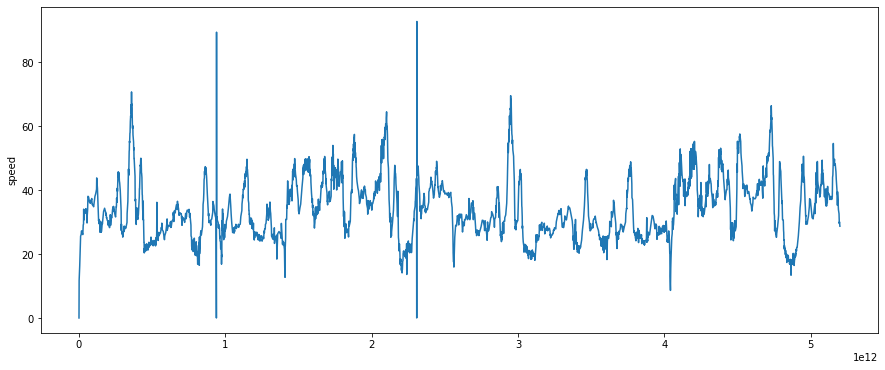

In [59]:
plt.figure(figsize = (15,6))
speedPlot(rr_2016)

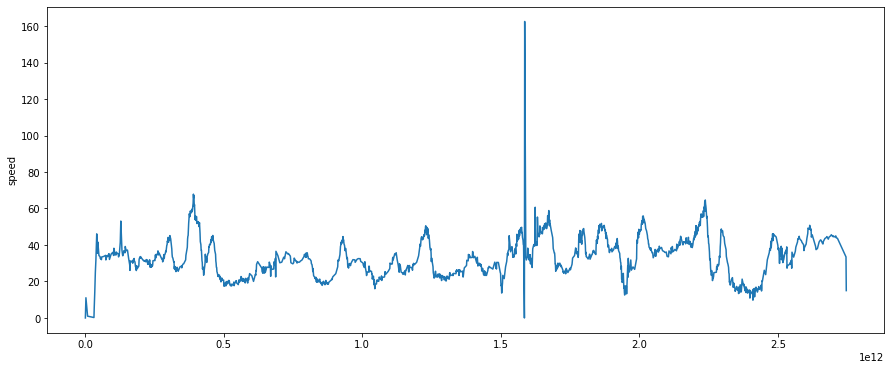

In [60]:
plt.figure(figsize = (15,6))
speedPlot(tt_2016)

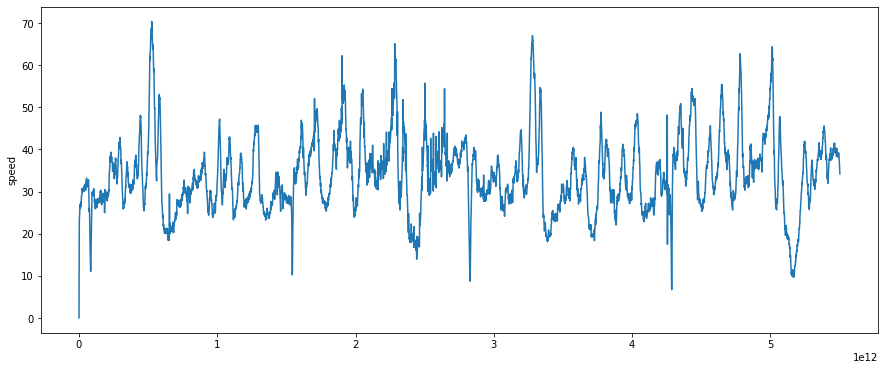

In [61]:
plt.figure(figsize = (15,6))
speedPlot(rr_2019)

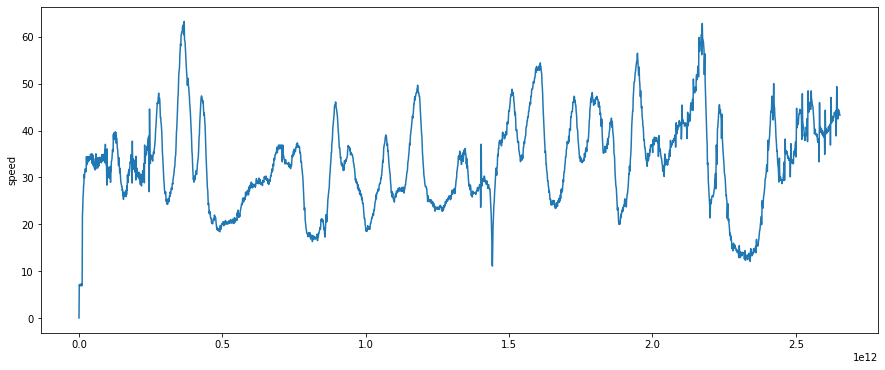

In [62]:
plt.figure(figsize = (15,6))
speedPlot(tt_2019)

## Notes From Speed/Time Plots
* The races from 2016 seem to have outliers/glitches in the recordings with the sudden jump up
* All of the races have a stop->start/acceleration point at the start, removing this would likely lead to a more accurate representation of the speed
* Both of the road races have a similar speed graph so are likely performed on the same course, this also applies to the time trials

### Removing Outliers
Making a new def that removes values over 80kmph and under 10kmph.
We will then create a new def that returns the average speed of the data set and compare the old average speeds to the new average speeds. 

In [80]:
def remOutliers(dataframe):
    return dataframe[(dataframe['speed'] > 10) & (dataframe['speed'] < 80)]
    ##dataframe[dataframe['speed'] < 80]
    

In [83]:
cleanRR_2016 = remOutliers(rr_2016)
cleanTT_2016 = remOutliers(tt_2016)
cleanRR_2019 = remOutliers(rr_2019)
cleanTT_2019 = remOutliers(tt_2019)

In [99]:
def compareSpeed(old, new):
    print("Average speed with outliers: ", round(old["speed"].mean(), 2), "km/h", sep = "")
    print("Average speed without outliers: ", round(new["speed"].mean(), 2), "km/h", sep = "")

In [103]:
def maxMinSpeed(data):
    print("The top speed of the ride was: ", round(data['speed'].max(),2), "km/h", sep = "")
    print("\n")

In [104]:
print("--Road Race 2016--")
compareSpeed(rr_2016, cleanRR_2016)
maxMinSpeed(cleanRR_2016)
print("--Time Trial 2016--")
compareSpeed(tt_2016, cleanTT_2016)
maxMinSpeed(cleanTT_2016)
print("--Road Race 2019--")
compareSpeed(rr_2019, cleanRR_2019)
maxMinSpeed(cleanRR_2019)
print("--Time Trial 2016--")
compareSpeed(tt_2019, cleanTT_2019)
maxMinSpeed(cleanTT_2019)

--Road Race 2016--
Average speed with outliers: 34.93km/h
Average speed without outliers: 34.94km/h
The top speed of the ride was: 70.71km/h


--Time Trial 2016--
Average speed with outliers: 33.53km/h
Average speed without outliers: 33.57km/h
The top speed of the ride was: 67.86km/h


--Road Race 2019--
Average speed with outliers: 33.88km/h
Average speed without outliers: 33.93km/h
The top speed of the ride was: 70.37km/h


--Time Trial 2016--
Average speed with outliers: 33.06km/h
Average speed without outliers: 33.18km/h
The top speed of the ride was: 63.3km/h




From this we can see that the time trials are slightly slower than the road races and also had higher top speeds. 

## Comparing Speeds throughout the Races
As suspected above, the road races and time trials are respectivley likely on the same track. 
If we can plot the 2016 and 2019 races together, we will be able to see parts of the race in which the rider goes slower/faster between the races. 

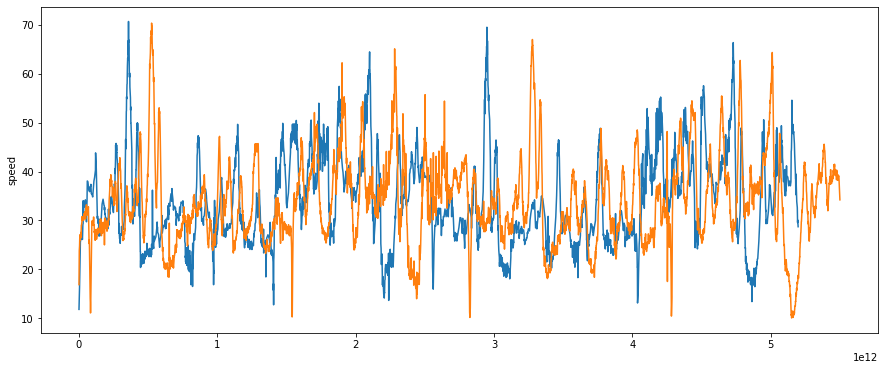

In [93]:
plt.figure(figsize = (15,6))
speedPlot(cleanRR_2016)
speedPlot(cleanRR_2019)

<AxesSubplot:xlabel='speed', ylabel='timedelta'>

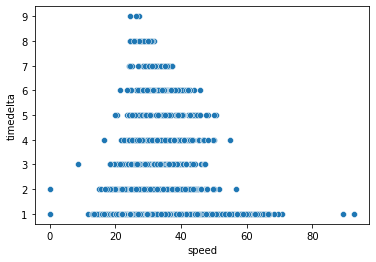

In [8]:
sns.scatterplot(data=rr_2016, x='speed', y='timedelta')
##sns.scatterplot(data=tips, x="total_bill", y="tip")data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA3sAAAFyCAYAAABMXcMCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAC4Y0lEQVR4nOyddZhbx9XG3xEuM9lrWDNDzHbIYYY2abhNMdhQv6Z10nBDbZoGGqaGGo7DiePYYccQO2amtXftXS/ziuf7Y+5ckK602l0t6vyex5Z0dSXNCu6dd84572GccxAEQRAEQRAEQRD9C0tPD4AgCIIgCIIgCIKIPST2CIIgCIIgCIIg+iEk9giCIAiCIAiCIPohJPYIgiAIgiAIgiD6IST2CIIgCIIgCIIg+iEk9giCIAiCIAiCIPohtp4eQGfIycnhRUVFPT0MgiAIgiAIgiCIHmHNmjVVnPNcs/v6tNgrKirC6tWre3oYBEEQBEEQBEEQPQJjbF+4+yiNkyAIgiAIgiAIoh9CYo8gCIIgCIIgCKIfQmKPIAiCIAiCIAiiH0JijyAIgiAIgiAIoh9CYo8gCIIgCIIgCKIfQmKPIAiCIAiCIAiiH0JijyAIgiAIgiAIoh9CYo8gCIIgCIIgCKIfQmKPIAiCIAiCIAiiH0JijyAIgiAIgiAIoh9CYo8gCIIgCIIgCKIfQmKPIIj4gXOgckdPj4IgCIIgCKJbILFHEET8sOa/wOMzgeLve3okBEEQBEEQXQ6JPYIg4oeDa8Vl9a6eHQdBEARBEEQ30GVijzH2AmOsgjG2KWj7NYyx7YyxzYyxf+q238QY26Xcd1JXjYsgCAKc9/QICIIgCIIguhxbFz73iwAeA/Cy3MAYOwbAWQAmc87djLE8Zft4ABcAmABgIIAljLHRnHN/F46PIIi4gymXJPYIgiAIguj/dFlkj3P+LYCaoM1XArifc+5W9qlQtp8F4A3OuZtzvhfALgCzumpsBEHEKYy1vQ9BEARBEEQ/obtr9kYDOJIxtpIx9g1jbKayvRBAiW6/UmVbCIyxyxhjqxljqysrK7t4uARB9EsojZMgCIIgiDigu8WeDUAmgDkAbgTwFmOMQcut0mM6G+OcP8M5n8E5n5Gbm9t1IyUIoh9CaZwEQRAEQcQP3S32SgEs5IJVAAIAcpTtg3X7DQJwsJvHRhBEf4fSOAmCIAiCiCO6W+y9D+BYAGCMjQbgAFAF4EMAFzDGnIyxYQBGAVjVzWMjCIIgCIIgCILoN3SZGydj7HUA8wHkMMZKAdwO4AUALyjtGDwALuWccwCbGWNvAdgCwAfganLiJAiiy6CaPYIgCIIg4oAuE3uc8wvD3HVJmP3vAXBPV42HIAjCvDyYIAiCIAiif9LdaZwEQRAEQRAEQRBEN0BijyCI+IEMWgiCIAiCiCNI7BEEEX9QzR5BEARBEHEAiT2CIOII6rNHEARBEET8QGKPIIj4gdI4CYIgCIKII0jsEQRBEARBEARB9ENI7BEEEX9QzR5BEARBEHEAiT2CIOIISuMkCIIgCCJ+ILFHEEQcQpE9giAIgiD6PyT2CIKIH6RBC6VxEgRBEAQRB5DYIwgijqA0ToIgCIIg4gcSewRBxCEU2SMIgiAIov9DYo8gCIIgCIIgCKIfQmKPIAiCIAiCIAiiH0JijyCI+IEMWgiCIAiCiCNI7BEEEUeQQQtBEARBEPEDiT2CIOIQiuwRBEEQBNH/IbFHEET8QGmcBEEQBEHEEST2CIIgCIIgCIIg+iEk9giCiEMoskcQBEEQRP+HxB5BEARBEARBEEQ/hMQeQRAEQRAEQRBEP4TEHkEQ8QMZtBAEQRAEEUeQ2CMIIo6gPnsEQRAEQcQPJPYIgohDKLJHEARBEET/h8QeQRDxA6VxEgRBEAQRR5DYIwgijqA0ToIgCIIg4ocuE3uMsRcYYxWMsU0m9/2ZMcYZYzm6bTcxxnYxxrYzxk7qqnERBEFQGidBEARBEPFAV0b2XgRwcvBGxthgACcA2K/bNh7ABQAmKI95gjFm7cKxEQQRjzCK7BEEQRAEET90mdjjnH8LoMbkrocA/AXGpfWzALzBOXdzzvcC2AVgVleNjSAIgiAIgiAIor/TrTV7jLEzARzgnK8PuqsQQInudqmyjSAIIvaQQQtBEARBEHGArbteiDGWBOBvAE40u9tkm+lsjDF2GYDLAGDIkCExGx9BEPEApXESBEEQBBE/dGdkbwSAYQDWM8aKAQwC8BNjrAAikjdYt+8gAAfNnoRz/gznfAbnfEZubm4XD5kgiP4JRfYIgiAIguj/dJvY45xv5Jzncc6LOOdFEAJvGue8HMCHAC5gjDkZY8MAjAKwqrvGRhBEnKD22evZYRAEQRAEQXQHXdl64XUAywGMYYyVMsZ+F25fzvlmAG8B2AJgEYCrOef+rhobQRDxCqVxEgRBEAQRP3RZzR7n/MI27i8Kun0PgHu6ajwEQRAaFNojCIIgCKL/061unARBED0K9dkjCIIgCCKOILFHEARBEARBEATRDyGxRxBE/EF99giCIAiCiANI7BEEEUfINE4SewRBEARB9H9I7BEEET9QzR5BEARBEHEEiT2CIOIPSuMkCIIgCCIOILFHEEQcQZE9giAIgiDiBxJ7BEHEIRTZIwiCIAii/0NijyCI+IFq9giCIAiCiCNI7BEEQRAEQRAEQfRDSOwRBBF/kEELQRAEQRBxAIk9giDiCOqzRxAEQRBE/EBijyCI+IFq9giCIAiCiCNI7BEEEX9QGidBEARBEHEAiT2CIOIISuMkCIIgCCJ+ILFHEARBEARBEATRDyGxRxAEQRAEQRAE0Q8hsUcQRPxA/iwEQRAEQcQRJPYIgog/yKCFIAiCIIg4gMQeQRBxBBm0EARBEAQRP5DYIwgifqA+ewRBEARBxBEk9giCiD8ojZMgCIIgiDiAxB5BEHEEpXESBEEQBBE/kNgjCIIgCIIgCILoh5DYIwiCIAiCIAiC6IeQ2CMIIn6QBi1Us0cQBEEQRBxAYo8giDiC3DgJgiAIgogfSOwRBBGHUGSPIAiCIIj+T5eJPcbYC4yxCsbYJt22Bxhj2xhjGxhj7zHGMnT33cQY28UY284YO6mrxkUQRBxDffYIgiAIgogjujKy9yKAk4O2fQFgIud8MoAdAG4CAMbYeAAXAJigPOYJxpi1C8dGEEQ8QzV7BEEQBEHEAV0m9jjn3wKoCdq2mHPuU26uADBIuX4WgDc4527O+V4AuwDM6qqxEQQRr1BkjyAIgiCI+KEna/Z+C+Az5XohgBLdfaXKthAYY5cxxlYzxlZXVlZ28RAJgiAIgiAIgiD6Jj0i9hhjfwPgA/A/uclkN9M8K875M5zzGZzzGbm5uV01RIIgCIIgCIIgiD6NrbtfkDF2KYDTARzHuVo4UwpgsG63QQAOdvfYCILo51CfPYIgCIIg4ohujewxxk4G8FcAZ3LOW3R3fQjgAsaYkzE2DMAoAKu6c2wEQcQDVLNHEARBEET80GWRPcbY6wDmA8hhjJUCuB3CfdMJ4AsmVthXcM6v4JxvZoy9BWALRHrn1Zxzf1eNjSCIeIciewRBEARB9H+6TOxxzi802fx8hP3vAXBPV42HIAiC+uwRBEEQBBFP9KQbJ0EQRM9ANXsEQRAEQcQBJPYIgogjZGSPxB5BEARBEP0fEnsEQRAEQRAEQRD9EBJ7BEEQBEEQBEEQ/RASewRBxA/UZ48gCIIgiDiCxB5BEHEEuXESBEEQBBE/kNgjCCIOocgeQRAEQRD9HxJ7BEHED5TGSRAEQRBEHEFijyCIOILSOAmCIAiCiB9I7BEEEYdQZI8gCIIgiP4PiT2CIAiCIAiCIIh+CIk9giAIgiAIgiCIfgiJPYIg4gcyaCEIgiAIIo4gsUcQBEEQBEEQBNEPIbFHEEQcQpE9giAIgiD6PyT2CIKIHyiNkyAIgiCIOILEHkEQcQT12SMIgiAIIn4gsUcQBEEQBEEQBNEPIbFHEEQcQmmcBEEQBEH0f0jsEQQRPzBK4yQIgiAIIn4gsUcQRPxBBi0EQRAEQcQBJPYIgogjKLJHEARBEET8QGKPIIg4hCJ7BEEQBEH0f0jsEQQRP1CfPYIgCIIg4ggSewRBxBGUxkkQBEEQRPxAYo8gCIIgCIIgCKIfQmKPIIg4hNI4CYIgCILo/3SZ2GOMvcAYq2CMbdJty2KMfcEY26lcZuruu4kxtosxtp0xdlJXjYsgiDiG+uwRBEEQBBFHdGVk70UAJwdtWwBgKed8FIClym0wxsYDuADABOUxTzDGrF04NoIg4hkK7BEEQRAEEQd0mdjjnH8LoCZo81kAXlKuvwTgbN32Nzjnbs75XgC7AMzqqrERBBGvyMgeqT2CIAiCIPo/3V2zl885LwMA5TJP2V4IoES3X6myjSAIInZQGidBEARBEHFEbzFoMZuBmS69M8YuY4ytZoytrqys7OJhEQTRL6E+ewRBEARBxAHdLfYOMcYGAIByWaFsLwUwWLffIAAHzZ6Ac/4M53wG53xGbm5ulw6WIIj+BkX2CIIgCIKIH7pb7H0I4FLl+qUAPtBtv4Ax5mSMDQMwCsCqbh4bQRAEQRAEQRBEv8HWVU/MGHsdwHwAOYyxUgC3A7gfwFuMsd8B2A/gFwDAOd/MGHsLwBYAPgBXc879XTU2giDiHUrjJAiCIAii/9NlYo9zfmGYu44Ls/89AO7pqvEQBEGQQQtBEARBEPFEbzFoIQiC6D7IoIUgCIIgiDiAxB5BEHEE9dkjCIIgCCJ+ILFHEET8QGmcBEEQBEHEEST2CIKIPyiNkyAIgiCIOIDEHkEQcQiJPYIgCIIg+j8k9giCiB8ookcQBEEQRBxBYo8gCIIgCIIgCKIfQmKPIAiC6FU88fUuFC34pKeHQRAEQRB9HhJ7BEHEH5TO2av556LtPT0EgiAIgugXkNgjCCIOIbFHEARBEET/h8QeQRAEQRAEQRBEP4TEHkEQ8QelcRIEQRAEEQeQ2CMIIg4hsUcQBEEQRP+HxB5B9ADXvbEWjyzZ2dPDiENI5BEEQRAEET+Q2COIHuCDdQfx0JIdPT0MgujVcEq3JQiCIIhOQWKPIAiCIAiCIAiiH2KLdCdjbFqk+znnP8V2OARBEN0ARYz6BJwDjPX0KAiCIAii7xJR7AF4ULlMADADwHoADMBkACsBHNF1QyMIgugqSOwRBEEQBNH/iZjGyTk/hnN+DIB9AKZxzmdwzqcDOAzAru4YIEEQBEEQBEEQBNF+oq3ZG8s53yhvcM43AZjaJSMiCILoaiiNs09AnxJBEARBdI620jglWxljzwF4FeL8ewmArV02KoIgiK6ARB5BEARBEHFEtGLvNwCuBHCdcvtbAE92yYgIgiAIArL1Ajm0EARBEERHiUrscc5djLGnAHzKOd/exWMiCILoYijCRxAEQRBE/yeqmj3G2JkA1gFYpNyeyhj7sAvHRRAE0XVQOmefgD4lgiAIgugc0Rq03A5gFoA6AOCcrwNQ1CUjIgiCIAiCIAiCIDpNtGLPxzmv79KREARBEIQOCsASBEEQROeI1qBlE2PsIgBWxtgoANcC+KHrhkUQBEEQBEEQBEF0hmgje9cAmADADeA1APUAru+iMREEQXQtFDIiCIIgCCIOiNaNswXA3xhj93LOmzv7ooyxGwD8HqL+fiNEa4ckAG9C1AIWAziPc17b2dciCILQIJHXl+D0eREEQRBEp4jWjXMeY2wLlEbqjLEpjLEnOvKCjLFCiDTQGZzziQCsAC4AsADAUs75KABLldsEQRAEQRAEQRBEB4g2jfMhACcBqAYAzvl6AEd14nVtABIZYzaIiN5BAGcBeEm5/yUAZ3fi+QmCICJAEaO+AGXbEgRBEETniFbsgXNeErTJ35EX5JwfAPAvAPsBlAGo55wvBpDPOS9T9ikDkGf2eMbYZYyx1Yyx1ZWVlR0ZAkEQ8Q6pCIIgCIIg4oBoxV4JY2weAM4YczDG/gwlpbO9MMYyIaJ4wwAMBJDMGLsk2sdzzp/hnM/gnM/Izc3tyBAIgiAIgiAIgiD6PdGKvSsAXA2gEMABAFOV2x3heAB7OeeVnHMvgIUA5gE4xBgbAADKZUUHn58gCKINKLJHEARBEET/J1o3zioAF8foNfcDmMMYSwLQCuA4AKsBNAO4FMD9yuUHMXo9giAII5TG2Segj4kgCIIgOke0bpzDGWMfMcYqGWMVjLEPGGPDO/KCnPOVAN4B8BNE2wULgGcgRN4JjLGdAE5QbhMEQRAEQRAEQRAdIKrIHkQj9ccB/Ey5fQGA1wHM7siLcs5vB3B70GY3RJSPIAiia6BQEUEQBEEQcUS0NXuMc/4K59yn/HsVVPRCEARBdCHUVJ0gCIIgOke0kb2vGGMLALwBIfLOB/AJYywLADjnNV00PoIgiC6ARERvhjEKwhIEQRBELIhW7J2vXF4ObZbEAPxWud2h+j2CIIgegZREn4A+JoIgCILoHNGmcf4VwBTO+TAA/wWwHsA5nPNhnHMSegRBEARBEARBEL2MaMXeLZzzBsbYERBOmS8CeLLLRkUQBNGlUMioL0CfEkEQBEF0jmjFnl+5PA3AU5zzDwA4umZIBEEQXQzlB/ZqWE8PgCAIgiD6CdGKvQOMsacBnAfgU8aYsx2PJQiCIIh2w0mUEwRBEESniFawnQfgcwAnc87rAGQBuLGrBkUQBNE1kHggCIIgCCJ+iMqNk3PeAmCh7nYZgLKuGhRBEETXQqKPIAiCIIj+D6ViEgRBEL0SkuQEQRAE0TlI7BFt8vCSHXh/7YGeHgZBxA6qBevVMEYWLQRBEAQRC6Jtqk7EMQ8v2QkAOPuwwh4eCUEQ8QRpcoIgCILoHBTZIwgiDiEVQRDBfLezEp9vLu/pYRAEQRAxhCJ7BEHEHxQy6hvQx9St/PL5VQCA4vtP6+GREARBELGCInsEQRBEr4Iq9giCIAgiNpDYI9qPuwn47t9AwN/TIyGI9kERPYJok33VzT09BIIgCCJGkNgj2s9X9wBL7wQ2vNXTIyGIDkKiry/A6XPqEbx+et8JgiD6CyT2iIi4fSbRu9Y6cfn+Fd06FoIgCKLraXL7enoIBEEQRIwgsUdE5ImvdqvXPb6AuOJt6aHREESMoHTOPgF9TD3D397b2NNDIAiih2n1+DHvvqX4fmdVTw+F6CQk9oiIVDa5Q69brD00GoIg4gHqqd6zHGpwt70TQRD9mj1VTThY78Ldn2zp6aEQnYTEHhERl1dL4zzU4BJXhh0tLsec2gMjIggiXqDAXvehZm4A8AUCEfYkCCIesFmERPAH6Ejc1yGxR0Sk0aXVbrR6FOHHlYmAM7UHRkQQMYDyA6Nie3kjiqti6Mz4zQPA9kWxez4iZtS3etXrPjJoIYi4x6ooBBJ7fR9qqk5EpNGlTQBUs5aAFICUa0X0Neik1R5OevhbADFssv3V3eLyjvqoduckyruN6mYtddPrp8geQcQ7PkXkeSnS3+ehyB4RkRG5Kep1Nc2H+usRBNFeGg9FvSujhaRuZ3t5o3q9KDu5B0dCEERvQEb4/RTp7/OQ2CMi8r+V+9XrblXsKZE9clEg+ix08mqLmEfVdn4e2+cjYsp1b6xTrx8xKqfnBkIQRK/gjR/F/O9gvauHR0J0FhJ7RNSoYs+vpPtwCu0TRH+loTXGvdY6IB5JkvcMerMWgiDik9dXlfT0EIgYQWKPiEhWsgPHjc0DoBN7HsWwYcObPTQqgugkVAvWJs2eWIs9EhB9gWSHlcQeQRA4YVx+Tw+BiBE9IvYYYxmMsXcYY9sYY1sZY3MZY1mMsS8YYzuVy8yeGBuh4Q9w1LZ4MDgrCQDglm0YPDF05yOIHoHEXlvE3KSjA2KPNHn3k5Hk0My4CIKIW0bkUe1uf6GnInuPAFjEOR8LYAqArQAWAFjKOR8FYKlym+hBWjw+cA7kpjoBAB45+XM39eCoCKILKFsPHFzb06PoVbyyfF9sn3D3l9HvS+XAPUaSw6plcRAEEbfUNHvU6wFqv9Cn6XaxxxhLA3AUgOcBgHPu4ZzXATgLwEvKbi8BOLu7x0YYaVH66qUn2gEAS7YobnoeRezljuuJYRFE5wkOGT19FPDM/B4ZSm/lue/3qtdjkta37eN2P4RTBLbbSXJY1WM/QRDxS0WD1o4l5mn9RLfSE5G94QAqAfyXMbaWMfYcYywZQD7nvAwAlMs8swczxi5jjK1mjK2urKzsvlHHIfKEn+IU7Rh/2l8nJslb3hc7BLzmDySI3grlBUZFVZPbcPvzzeWxfQH6HHolR43ORZLDhlYSewQR99S1anO8RheJvb5MT4g9G4BpAJ7knB8GoBntSNnknD/DOZ/BOZ+Rm5vbVWMkADS7xY870WHVNu5YpF33k9gj4gCfG2it7elRdCvXvGZMaV0UC7E39AjterTHDtKE3YJM0Ro3IBVJDiut4hMEgXoSe/2GnhB7pQBKOecrldvvQIi/Q4yxAQCgXFb0wNgIHa2KIUuSw4p5I7IBAPyDP2o7BOjHT/RV2qEi/ncu8I+iLhtJb6S62RjZGz8grfNPuu977bq3JeKuVLLXvbz7UykA4Olv9iDJaaM0ToKIc95bW4pdFU1IVTK7Gl20uN+X6XaxxzkvB1DCGBujbDoOwBYAHwK4VNl2KYAPuntshJEmJbKX5LBh/hgRRWUtVdoOFNkj4oG93/b0CLodvxLpmTFUmCJbWIzll4+a9PYmbnxnAwDgwllDkOywqlkdBEHEJ6+vFD32BmQkAKDIXl+np9w4rwHwP8bYBgBTAdwL4H4AJzDGdgI4QblN9CC7K4QRS36aEwl2q/HOYUdRzR7Rd+kjNWMfrj+IkprIUbCuYHelaK+SleyAzcJiv6rbRmRP0jc+pf7DnOFZSHLY0OT2gfeR3whB9GeWbj2EmxZu7Pbf45TB6QCAe382CQDQQJG9Po2tJ16Uc74OwAyTu47r5qEQEahr8cLCgMKMRCQ5bPiN9TPtzvyJwAGyqif6Kh04cfp9gLX7Dpn+AMe1r69FQVoCVtzcM4dGh82ClARb51Z1vS7guaDxe1s7NzCiyyjKSUKLx4+yehcGZiT29HAIIq753UurAQBXHD0cQ7O7r+9dk9uPnBQnhih9lhsosten6anIHtEHaHL7kOK0gTGGwZmJuM62UNwx9WLAYqPIHhFf+N1t7xNDiqtFdK28oXtTHvUryHarBU6bpXOtF6p3AYc2Gbd5o/ubKLjU/YzKSwUA7K1q7uGREER8o+9tt628sVtfu8HlRVqiDQmKQZ/bS3W8fRkSe0RYGl0+pCaIHntFOcnwykCwtwXgAVF3U1fSgyMkiA4SrYqoL9Wu+7pX7D359e7YPuHnfwMW3xr2bpfXj9Me/Q5fbtO8sZw2Cxw2Czz+Tog9ZnKaqY983Ih1iSARPUnK5G5PZVMPj4Qg4psmnSvu9u4We61epCfa4bCK47fXTytvfRkSe0RY3v2pFAfqRLpVXqoTLjjFHXkTgOWPiesPT+yh0RFER2jjhLXsEePtg7pU5UD3rmxOGZQe2ydc/hjww6Nh777/s23YfLBBTRsCgKvmj4TD2snInllE9O1LQ7eZQE3VuxfOodZn3/rB5h4eDUHEls82lmHnoe4VTR1l4U+lWLZTM8TbdKC+W1+/odWLtAQ77IrY69Q5gOhxSOwRUcEYw2bHFHHjyD/17GAIoqv44jbjbX0EsJtbjaQl2tXr3dHkujKokfrvjhiGIdlJcNiscHfmRN9crV0//o6OPw/RJbh92ndrVH4KHDaaFhD9j2e/3YMr//cTTniob7gr/+mt9bjyfz8BAArSErCnm9OqG1w+pCXaYbUwWBjg7Ux2Rx/kp/21aOlH/UbpqE5EZESuVhCcaPWjwloAWKwRHkEQfYEORIwiiD2X14+DdbE1HbnujXXq9R+Lazr3ZPqopM9jukt9i7EGV6bzdTqNs0FJhb1hCzDvOnF9xu+ieijV7HU97689oF6fMDAdicHOywTRx6lodOGeT7f29DA6zNwR2d2y4KdHRPZE6Y7daokrsVfX4sHPn/gB176+rqeHEjNI7BFhcdgsOH58vnrbybzwQIk2jD65h0ZFED1E6aqwd137+lrMu//LLrPH9gU6eaLV98T85h8hd9e3evH9rirDtotnDwUAOK0WeHydmGjI17Y6AIsFcKaJ60SvIDhqW5CegFF5KRicRU6cRP+gtLbvuv8m2C1IcdrQ2o0GKZxzxaBFzPccVgtccWTQIhc31+6v7eGRxA4Se72ZXUuA1f/tkZfmnMPjC8Bp1b4ijU0taPAqt899QduZmqsTfY2OiLIv7gh71+IthwCgcxGwCHS6qfmPz2nXy9aH3N3QGvobLkgXzXQdnXXjlGYssm2F1dGmsykDObR0F/5A6G9hRlEmWj3xs5JP9C32V7eYfm+DafH48M2Oym4XKp9vLsdH6w/G5Llc3gASHdZuTSls9frh9XOkJ2oGfbL3ajwgz7f9KZpJYq838+o5wMfX98hLy0mrU5fS44AXHtjEQdaRDEw8V9zx9NE9MUSC6AQRJgrhomhR1OzFyrFsy8EG40t3NmIoDZWANp0wg+l0Gqc0vbEoWQFWB+A3TyUNhrI4ux6zSXOyw4Zmd/+pVyH6DyU1LTjqga/w7y+2t7nv+Ns+x6UvrMLizYe6YWTAgbpWFC34BJe/sgbXvB67PsSJditc3oChFUNX0tAqfvtpiht7QXoCKhu71426J5Hvs6+b3u/ugMQeYcrBOtEHKytZS7dKd3C4Ydetdig/hIrNwE8vd/MICaKLkKLO3QS89cvQ7RGIiWNZ/QF46w4YNrV0tl5D3zaiqSLk7kgrmJ1y49SLVKsi9myOsHWDRPdjNqEpSE9Aq9ePqqb4meARfYOKRjE3Wb67OuJ+K/do9wen4+nrVGPJDW+u65LnlfXTrs6k07eDBpfI9EhLFNkYOSlOVDfHz7HAr5y3KLJH9HtqW8RkTKZyAcCAFAYPt2k/gMwi7QFrX+3G0RFEJ4kUKZOi7r5C4/bmUJEUTF1LJ0VMbTHw0HhMeWuOYfMfX+vkKnGrzuAlKSvk7kgRyU6lcepTvNXInjP6yB45tHQ58i0+enSuum1ioWj7sbGb7d4JIlrayja44tU16vX1pcbv8fVdJMqCG493JvVSb5SUqIi9Ti/6RcmJimOpTGfMTXGgptkTVepsf0D+nf2ptyCJPcIUt1dJ49TZcNsCwqBF/QEcvQCwK26djuTgpyCI3kc04iHQ8RrUTouyp45Srx5tWY+YJTKmKcI1fyLgCp3ARxJzTpul460XNr6tXbcox5Io0jj7ZFP1iq1A+aaeHkW7kWXZD58/Vd02YWAaGAM2lpLYI3oXizaVAwA2HWiIuBjUE9P0I0blGG7XtXT8XBLgHE6bBS//dpZaO1fb3PUZEXpXaZnZlZPqRIADNd3w+r2Bzvqh9UZI7BGmyN5LTpu2umTlomZPnRjaHEDuGHGd0VepX/Ldv4H/zOjpUXSanYcacd5Ty6MTLY/PAco3Rv3c+uL/LWUNEfZsg9Y6wK1Nrl9y/AN/HVHa8efTkz0CGDIXGHkc4AodY1OE+qwEu7VjBgd3pAMfXBW63eYwppVGoE8F9p6YAzx1eE+Pot1IIxZ9X8fUBDuG5SRj80ESe0Tv4tnv9qrX3/2p4+mYXVGDVqaUv0gaXR2P7HEO/PaIYThqdC4GZghn3IP1rjYe1TlW7a3BvPu/VG/PGZ4NQKRxAuiRtO6iBZ/g2hjWP0ZDp92veyE0QydMkZPiBLv2FRFiz44D+n5ig2cDALbWWVG04BOUd/HBiOgcLq8fa/a1o2fb0juB6p1ASyf7vMWIj9YfxMvLi9vcr8Xjw9Pf7MbLy4vx/Pd7cekLq8D3/YBt22WvpQgqovEg8N9Tox7T0q3m6Z0VjS78ENTOICJ1+0M2jU7WHNA6daL1e0XNnDNNOGEGia361vArtokOa+dtvy9+V7veDoMWoutp9frhsFlgtRjDqTnJTtSbuLQSRG9hfUld2PvaWija2pmFuTAsDKoFbHR1LrInf5JS7B3o4hYSz3+/R71+1fwR6vVsJcLXUzW8H8bI2TRa9IZo/aVumcReX6AHlrel2NNH9uzcCy9sKKvXHXBOuAsAsKRcHIweXrKj+wZJtJs7P9qMc55cjuKqdtooP3ts1wyonVzz+lrc9sHmNvf767sbcd9n23DbB5vx94+3YFDDWrztvAtTip8XO7T1m3IbJwKP+86El1tN8zssYVIOr3z1J1z03EpD1OyHdZtRUd9i/gAeKqhSEp3q9U71ivJ7RM1cgqjFCo7uNbm11z5/xmD858LD1NsJsXCCG3W8dr0HxF6T2xcxetlpipdp103SZHszLq/ftJG6026By9v/VriJ/kNDJ8TU/powx+EY8pwuCtlehNgTJ5eCtAQ4bRbsqWyK1dBMsVk0SfCXk8eq11OU5urdVTPYFdS3enHqI99hV0Xb76G+HPRnTywLv2MfgsReX6AH+tjJQmN9zZ4DXni4DdVNuomazQHYEmGHmEgFrw4TvYtNB8Qkv90r9rV7RZphH2FLUPrZNbb3OvV8FTwTduYHWkId4MLVl+041AhAq7NY8PAzmPf+PDz1+D/NH2AiJA/L0bY5rB08XO9aCjQeEiIrMVNsazFGHPU1e/84dzLOmDJQvZ2ZJNL7ajprPiOx2sM7m1ZsBT68BlbEdlIx4+4vMPH2z2P6nAbe/rV2fe+3Xfc6XUCrx1zsJXY0fZfotfz94y34yzuhfTb7KpFqyNoydzrU0PVZSIs2l3f4sQEOMOXkYrUwDM9Nwa4uFnvhFsSkCDQzaDn/6eU4+/HeJYgCAY6iBZ/g3k+3qtu+3l6BLWUNeGTpzjYfr/87S2q6NpraXZDY6wv0QMqTGtnTpXGygAce2FEdHNa2OuBQxJ7DRl+pvkCHDDAqtsR8HF2B2+cPaQB7pDXYOCPKKNWxt+CbU5eigmeIRzWWRT0Ov75XT10JZlZ/AABIaA6TkmLS/86x9Db87dRxyvN0IMri8wCv/hxoKBUiJGe02F6x1bCbO4Kl9+DMJACiv1VMsNjCi71XzwF+ehlDENu+WF0eoRowRbv+2V+79rViTKvXr7r96RGNnEns9See/34v3lodozrgHiBYwOkzj9pLWTtLTjaU1nUorXnBuxvga6eFvxRd+rnWyLwU7O5isWdXFhTPmTbIsF0u4pu1aVm5twbrSjr23kTCH+B46YfiDj32lRX7AADPfKulpcq/IZoMleC+toZstj4Kzcz7Aj0g9lzeUIMW5vPAYneiKmg1jVvtamRPTgzjkSa3r9dbxfP2eJQFiwur03y/biKSINEz5pZFhtvHWn7q2AumDgCOuhFNCYU4xEVEzFtvJvbMlbM8MQZKVgMPT8Q51u/FcyDMBOXAapONHGMKUgF0sIefXlTljROGSswKHDKmwsrnXnnzcSFPMThLEXsmaaQvLhP1kKHDjvA9s9iAQJjPUsli+MRyg3j+H4rbPVGKRJdZh9ucWtR07Gld8xpdRKvXjwSTyF6ykxqr9ye6u+6pKwj++eoXo4Np65feHn8BzjnOfGyZ+bHOhLOmapkRb/xYYnrsjMQ7q8XC3/9WanXcI3NTUFrbGtNoO+dCUMnaQqfNgsKMRDxw7mTDfjZFKPkjLDgu2RLbBbp31pTg9g/bLtkww6xljJVJwdr2+SS4v94H6/r+b4fEXl+gJ9I41Zo93VfE74bNkRAS2fMzTex1V9PP3kZdiwcTb/8cx/zr654eSlia3D41jTMqPEGriFa7+X7dRG2z9jsId8Izm8yPZCaObdHM+QfPAiDMXiqQAQDw1LZ90H/i613wB7gqoBYu/spwfwoLM8nQCaTfev6sXpcT8Q7VnNXrVvFPvFuIkvRBIWYwcqzSalvPoExRj2sW2bvjoy34Zkdl6Pu+52vt+pSLjPdZrOGPaRlDDDef/34vvtpeab5vB5ANmWOO3yPGbnX0uTY0omYvdCqQmmDrlJsg0bvQOxr29kXJcARP1KsiOGpG+u6eMrEA5e1I45THt3URDGH06NuYAFrf4mhpMTm/Dc1OAufG1gidZfnuatz+4WZVVH2ysQxuXwCWoHIcNbIXoe9crL9RDa0dP/aYzQMsqmBt+/Eyo2FErjiWl9Z2fX1nV0Niry/QA5G9/3wp8ppVsef3ATwAuyPBWLMHIGCxwc4UsRenBf3vKS5cxdUtnTOy6EL0J4mo0kGCxV4PNj9zef2Yc99S9XZ1mFqNp77ZHbLN39HDXNkGAECz24dKJY2zqSo0BSp44vTPRdvx+5d+VG8H22WnIYw5ji7a9WVgmnp9WIr4W/dVd+CE89ovtOtD54rL1AFAUDqqxx8AY9oKrp5kpw1ZyQ6jC28Qe6uCviuttdr1ab8y3hcpjTNjcMimkLTxdqI3cegyNzufW0S+LfYeWZzrDK0e8zTOVKcNHn8gJKLOOcfbq0tQ0Q01T72dl5cXY3En6rK6i+Datqe+2RNmz95NcFAm3HkgEg+dPwV5qc52fX/97RTHLOhcWR/Ub6/B5Y0ouL2+0PtSFZOUWBpNyUX9mmYPVu0Vjttm7pM2a/g0TjlHrGmOrWtlZ6YbZuOUkb39NW2b08n3+JELDsO0IRlRmbr0dkjsdRelq4HHZwOedrogAjEVewfrWkNC1GZI0aYetPzih2x3JoYcDHzMrtbsueO0oP/Oj7R6tq4uou4o+tWpG96Mokjf3Wi83YOT2IeCXF4/CpOSFGzFnW134UTrmo69aPog+AMcd3y0BW44UMeT0VwdKvbMJgL6aNQ8izEVJYs1Bu8uUJq5N5/3jmFzhl38pho6UhPRYJJ2mpoPNBlTbjy+ABxWS8gkRZLstKI1Qv3WzQsjNBN3phpvWyIYtHjFBKyea9Gxuk7WguhTcAyCdfdXohfgh9d26vkBAD4XYE8Q0e++JvbCuHGmJohIfnCEZEtZA258Z4PB/CAe8fgCuO2DzbjslQ4eX7qR4M/qvbV9s24vOLLXnoWgDMVo6oTxBUhLtKPJ7Yt6YTba9O9khxW/O2JYyHZ9ZO9AXSsm37EYL0aoRzPzuUtxCrEXy2i7Or0L8IjGPZFq9mTmyYo9sW3PZOmE2jP7XOXfsONQ2/Mzmb6e4rRhZF4KiT2iHSy+FajcBhxc1/7HxmjysGJPNebd/yWm3LnYuKrkc6uTrLAofbmcCaGRPR9ssCvueXVBK1io2Bp1A+X+wvbyMJP5Hua3L2o1YWMLUiPsqbDkDuPtb/8V2wG1g6eDVqLv/2yb6X7SIhoAbj19PNZM+hCzLWb7tnHyPupG4IxHDJHCCp4BX33oKv7y3aEOnXp+YTO6M2YinNjzAcl5aB50JACgMmMqAMC+8zMk2q1o7MiKLjM5xKcOABqNf8fakrqIDecTbJGdGeuC+/Q16XoPBkfrItbsiedJZ82qI2fIMaWd3Pq+JkQP6pser3pWXP70Uufb27RUA4lZgKsOWPV024t6+1cAD4wCqkMj0d2Ny+uH01TsmU8uZa1TR6Iq/Ql9v8/enhYZbNlf1dQ3P7tg0VXb4o1q8RoA1t12IorvPw0pThvSEuwIcKDZE90xNVqx5/Vz1eTklIkF6nb9MUy2PfoiQo2brEXMS9Xq5LOVxuaxbAavmpZwHrEmXHXjNHmvZeQ/2hTXaLFbOyb2mtw+fLIxdJFz5d7oxagUe8mK2Ktq8vT5nqMk9roLuUrBO5DmGKPI3gXPrAAg8pENK9wPTwIe0Bpomq52KSl9zsQUNLp9homfj9lghw8pTpsxqtVYDjwxB/jkTzEZf1+hzf49PdCgvE63sjg4KzHEbcqU7Z8G3f4kxqOKPRe73kBxwkVgCIgV1rp95ju29fcfewuQPcJgz13BM2BrCT1B64vooyEzXGRvx+dAc4UquuozhAsnltyF1ARbxyJ7UuxN/7W2LTlX9BFUFni8/oCawhMOp90SKgb3fI1BTEQwQ1ZLF+kcKWVvP0nlNuEOaib4AtrfmAnxnLUxFBV14WpnNrwV/ZP4fcCmhcbvUHOVeF8lFWGiXt5W0eNwyZ1AcwXwn2ki42NHF7aFaAOXN4AEE1dDGdlrChJ7Fcpk87udVdhX3YFMlX7CPxdtV693aCGmG/lpf53h9mClDrev8fePQ39XkdovhCPcQkY4ohF7nHN4AwE4FJHy6IWH4cv/OxqMGbMTpDiN1KYqI1HUTj936Qx128CMBACImE7fXmT0LBAAXBHEXrjIHudczQJriVI4R0tHF/nCGcXoF24/2RDZVVv2nU1x2pCrCO7OlhP0NCT2ug35w+7ACmAXpAV5ZaFt/QGR0qWrz/KYrZTVCXcophgo6A+wXgixN3dEtrGQ9cEx4nLtq7EdfC8mJ8WJ/ZFqqza/B/xzGA5jbfd6iSX3fapFt4qyk1Fa2xp5NfrVc7Xrx9/ZhSOLLVP2iqbp1x+tGH00a1G3dWx8+59vUAYA4IsbjoI1fSBSPFVh9x2aHZ0TbSYLkxKi1NGpNVJ2ZULmrkdaor1j6TtS7Okj9zKt0tsCt8+PN38MbfkQjGlk7+Wz8L3zOu12yY9A5XbjPmc8Evpk0nXUpNUE/F7V9fVoi0grOtgO2+tAgBvGqV+4yklxGFdn9YtoX98bfXTvu38B7/wG2P6ZNmZXHZCco+1TE6Ym6qUzgPsHA/t/0LZVbgPeuyK61+4C3D4/EkwMWrS0MeP556aFG9XrPxbXIl7RnyeDs116OyNyU3p6CB3i3Z9C0087Yp6RlmieohyOj9oQB4AQhJxr7QvsVguG56YgPdFuWGSSJif2CH1TZWlAri6yl+SwISPJHtM2AKrY4zyiaE5x2pBotxozI6DV/NmtDC5vIKYR7uD0/WifO5rsz/fXmZi26ahsdCPBbkGC3YKMJIfpePoaJPa6i3ZG9pZu1a1OxCiyNzhLW83bLJtOP6SbAPvE67iVlZorjh6hu0/8yB1J4iShLxL2wQYH82F0fgoqGt0ds4jvw3DO4bRZcNlRwzEoMzHyytuebwAAEyzF3TM4Bf0k97AhmWjx+COvnO36QlwOPUI4OPYSLpylpQSarbT5LeLAfPXhSgpNo1avNWL8NN2eEU4c52uLE3JCl+y0ocmehYxAXcjux4/LAwAUpCW0NXwAQAaaIp645EqpjWn7ZCU7tChjwC+apEdDYoa4TMrWttkVUeppwk0LN+KW9yPU2ykkBDfYDhr/ioRrgeePBx6fZXzg+LNDn+yEu8SlWYTb7wWGzkMzS8Ikyx6cNmlAu/r7PbB4O8beukgdq3QHvumUsUhPtBvMWlC7V3e9OMS0JixlSm2Lt8X4dyRlA1MvFterTBZzyjcBpZpxDxbsB45Qsh68rSI62AO4vAHT1gsy+tEQYUIcyYq9PxO88NGbV/31aX9jC1IxMD2hT6Wk7a5sMhV0UwdnAAB2HhLHU32LlraEQZJiSBRtGufnm7S093AtgOQCuj2o13BGot1wrpUCKVJkT0YSrUHKZUB6Yojg6gxyCG2Zf1ktDJlJ9pDvjZwrpiuRyEilAO0leH6ypyq6LIJwded6RuZFXuxYX1qHMQVpYIwhQ1kYCJsV0kcgsdddqGIvutWJ372k67kViM2B+cTxWg65aWqUYscuD2Z6cagKTqv4UevTGjywwQEfspKd4BwRjRz6I7srm+H2BTA0OwlZyY42bJa58n/3OluOyBOGF3edNQHjB6QBiJAO4g+Kfgw7Sly3htrydzczhmbhyYuFaPuxOFQsuJkYo82nnLwsWg1fasFwbcdwv8P8ScC4M9SbMuXGYbNgS6UXTubF7gqtfUVdiwdLtor6NLlKPDBdE33B0b5m7kQi3HBF+I3I3587c5S6bVh2MoplytyS24EHR0eXDlx0hLg87lZtW4L4/A+WlWHhT5FXOCVOW1Aap24BKjeRoQA6oeLStfeQYlNPgdLDyayWN+AFrA7UBRKRDBeykh0RxUYwT34tUnW+3CY+E5mCmOS0IT0xaLJSvcv4YDMzm5DxBbT0Zllv16L87ck5wNlPAJnDgKodoY/94jbj7YR04PjbgQteB3ytwI/Ptf36XYDLax7ZS5NpnBFSFM0MG+KBigbjd7c318Dd84kwD8tJcWDR9UdhaHZynxJ7xz34DY74x1ch208Yn48B6QlYsHAjbnhzHUb+7TM1Ch1cn/X1n+cbbsuoWqRWAnr0i0Th6sXlwmCwo3F2ilNt+eLzB3D1a6LvayTTD1XsBT1XYUZCp1ovtHr8OO3R7/DDbnHMkj9f2YbisYsOw/KbjjV9bILdGtJaS97OVlr2xNI8pr7VgzRdDf7KThjABIv/rKTIc5lmtw/5SlRVtiPqa9H7YEjsdRcynaoHa/Y8voCammN6cmoVPyatx55utVdOzJQJv77my8NtcFr8qgWv2+83Wq+POjEm4++tSCvf8QPSkJFkjxwx++kVAMBVtg+6Y2gqj38lJqZnTSlEbqr4DM0slgEYzSWGHQnkTxCfYV770yA7wmUvr8bPn1hmet8Ro3Jw1GhRG1VsshrZypWDuIy66EV1oVb/ELa5vG5V0OMLoLhKPI/DZoGbi99OfaP2/uhPbo1u8bnffuYEdZu+wB4AmpAIK+NoaQ0ae6nm6CdXS+tGnw8Mng04UjEsN1krEt/yofLHRpFCt/51cWnXFm7u+E6M/65XPjV7hCkhkT1dmuLw1KATvKsu8pPJRQO/yffP7wW32tHCE5DEXEh0RHYBDcdV/xMTKpl6k5lkDxV7CrXOQeKKLgocFn07ko1viSirjMglKWmcOaM1Ien3Am/9Clj/BlD8PTDnamDiOcDPntGeZ+ypQgDv06V2dhNefwC+AA9Tsxeaxhk8Qe2seU5fRabZycl4dYxt52OJVTHXGKOYcoX7HfRGwkXRAHGonjNcZCy8rzjuyu9jhS6aee/PJqEox9j7UusbF3k+drCuFe+vPYANpVqT7tdXmddoPybbVQVFyQdnJqKkRgg0fW3z3qrmsNGicGJvYEYiytrRDD6YLWX12HywAX99dwN++fxKfBCUzigEtHk9p9NuDXFbl+eEfGWBsz7YqKsT1LZ4VVMaACiPMn3VLGAaHHFsaeOc4vUH1AhtvpKxUxFDY5yegMRed6G64vVczZ7b50ey04rR+SlYW1IXGt1QVuTlAdbYUF1G9sSPT5+94+FWOJkfDin2vAFRCyjxdlFvq16CTLtLctiQmdRGZI+L97aQRXZwjCX6E2aiw6qe/MOatMjPK38icPQCcd2ZGtqKoYtYvOWQwVCAcw7GgGuPHYn8tAQkOaxw2Cwh0WnOOZr8ykqgFKzye5s+2FBTFTYgoRN7f3lnPV5YJlL9Uhw2eCAiHRauva48KV86d6gq/NITtebzeUGpnflM/F0+d5DYe/lM9aq62OKwAUPmAn43xuSLidrmg/Xa79bXxkk/zOf17l4xviHMmAoqX8OMEIMWXbP2CfYgkVSrmOIc+WeYItOCzY5rfi8CFhua4UQy3EiwW9Hq9XeoFsTjC6iTv4xEh3GSq3vtD5qVRYyGdoi94ccIQbdjkTGyBwA5o8R9gQCwaymw5QPgvcuFuB15LHDuC8CU843PO/RwoGSVmkrfXcjJmlkap9ym7536+FdCxEo331imbfUl5Pv27/OmAOjdonfyIGGQ9PezJgLoW2JPv7gQbBzHOfDnk8aEPKbR5TU0kDcrjZNOj17lOf/1+XYULfjEkLFU2+zBvPu/xPVvrjM81uMLmJaqPPvdXvV+PUOyklBWL1peBWfThHOwlOfm4ObmuSlO1Ld6sTfKlEY9mw7Uq2KzpKYV3+2swhtB9dpOk0UfSYKJSZe8XZAmjumx/B3UtngwSGckFK0JEgvKmvIHeIhz8J7gvrBBePwBOJUvToLdiswY10r2BCT2ug3lC7jx3fY/NEaRvWa3HylOGyYVZmBHeWNIry24hdiTJ3eD2FMie8ympHHqJl8ubkMi82iRPV/AWCUbzqygnyAjDwl2CzKT7Gjx+M1XJFvr1KubAkXdMzgYXePsVqbWAYRd1JRRsXnXAsrn3Z1iL5g9Vc3gXGurwBiD02rBx0FF89XNHjQHFKElJ+XTLxWXv1sM2DThFdZdTanH4pyrq8WAOOnmZogJbsCjrfDJNLZpQzNVsSf7OQFCJJrh9wSJPV0vOsNii9UB+D2YNiQDjAE/7q3VetQF2ftHK4iaIN6HJGZcqfzsuiPDPkZE9nRfmLe0Rum3Vf/VuPNLp4vL4fPNn8yqvD9h0jj9sGmRPUVwtHagf+emg/V440exCp+WqKRxKpORmu+1lMl7/ZeI3n/RiD238r2a9AvxmJJVmglQkk7s+VzCgGbj28bHDz3c/HmHzhOpnGXrov3zYoJ8XxNMmqqrE2LdgUJmA6Qn2uGwWuKuPlsi37e0BDvsVqZatfdG5DEqO1lMyFMTbDFtzN1VcM5xzWtCtOWkOEwXFgozEtVFZkBMO4L/NrMaLtlKQEb2nv1OzFH033Wz9+jen01CgAOrTUoIJMGGRoOykhDgIkoYPC8ItzAcrmZPir9j/vU1DtS1Ys2+GrwWpRv06f/53mCu1F7MTLrkbVmvHkuxV9/ixeCsJCxbcCxyU51Rp4gGf9zF1c34ZIN2bM9IsmPjgXpEwuMLGAx0CtITURbDWsmeoMfEHmPMyhhbyxj7WLmdxRj7gjG2U7nM7KmxdQnyG7j+tah2N6R/xSiy1+j2ISXBjqHZSShvcMHtClqpUCbz6mRTv9orU66UVXl9VKgOaUjnDeqqkMcXMEYdGg5ok6R+iDzxJ9qtmnOT2UHvy7+rV0t4buj9XYS+7x9jTE0NCWuuICN7utS/nhR75z4p0tvydVGyRrcPB+paDSu/uyqa4IYUe4qYciiF2KkDDH9PW+k75Q2hB/bTDisCADQ06Vabld+BzWJRT9DSNhsA0nXCTw8PFnuzLlOvamnUFjXlMd3JMCY/VdQpynRD3XGhaMEnuPaNdUEvYv43cljg4nYkwDjRCF5F1uO0WYwpPN7QFNoQzOr1AF0ap8lEx++DK2BBMxKQDBcK0sXxJhpTAmmUNDxXpGz9uLcG3yjN7YdmJ8PjD6DB5UOjy4snFmuTHg+3wZ86IDqDFtnKI2sYMGAysPdbJbLHgKQscV+2UmtZvVMsHqQN0h5vN0+RwtB54nKfefpye+Gc48a31+PCZ1ZE7I/YrFqMh4o9q4WBMeMEOC9V/AYfvfAwpY4zvuqzJfI9ddotSHLY2kwL60nk52e3id+3zWqJulatJ1lfWq+acgzOSgr5HstFNadB7LGQ2qrcFGMqPQDY1IUMJYLGQlsLBKdQnjdjEGYNE9PSKhPPA4ciDmSpjGRIlqjb3l/ToqboXzRbupqbz+2C04QlX2/X+pcefv+XOOfJ5bj5vY3dYhCUYLcYF/ygBQZkGmesHCvrW72obvagMCMRhRmJyEpyhIjocATXTH60/iBeXyUimI9cMBUXzByC0hrNjfyeT7bgn4uMdZhePzcsIgxMT+hU+mxvoCcje9cB0DdNWQBgKed8FIClyu3+g1lz4wjkJOsmiTGI7PkDHN/uqMT6kjrVNKK8SlmdOuUBcSnFnmlkLziNUzso7mhJQgpvRiJT3Dx9flGfAmj9vcxs1vsJLt3qeKYi9kxX7HQGEOnovv5U3+8yuvxpYi/MA/YKx1DVtREAnOki8tAFbUDC4fUHsKuiCbWKcNav0N56uki9k/WSALCnshmtXDmxy6jXD49CeXBQZE/3x5ukzunFxWMXHQYAyMsUxia7y7VaOTlp0p+U9WmcV80fgYPpmgtogIlJdSBY7Mn07nFnar8/u1WLgvm9mDUsCxv365qVK8ZNK/eIyNJH64MiU1LsJWSE/H0JzIsTLGtCtocjwW7VVtbXvR7lg0JfFwDgUOpnWs3cOD2obuVoQBLSWTMGZ4rvYEkU9ur/XVYMt0/0Vxyek4wfi2swoTAdUwZnID3Rjj2V4jvx7Y4qWGH88jc5cqOL7Mn+ebljhdPowZ+AkpVAYiZgUQRTjiL2KrcLcTjh7LafNzkHyBkTs7q9JrcPb68pxfI91Xhrdfhjr4xIpThDFyUYY7BbLYYWA61eH0bmpSA/LQEOW/xG9uRvNMFuRbLD2qsjZV7VHl+2BGDw9QEX1eDsC310/x/nTMIFM4VgCk49/NULq9Trv5wzFPPHhC6sqgYtAaOpilf3fbYEhYhyUpyq62S9yfn9tMkDAACXzisybB+siL2Smlb1GHrNsSNhtbCwPUTl/Cp4DLL3ZTBbyyIvxAanwC79v6Ox+pbj1dsv/mYmFl0fPrMDMKnbhjb3GSDFXowcK6V4LcwQi2Mp7YhGBwvOhT8dwKBMIRrPmlqInBQHPP4Ayhtc+HjDQTz73V488fVuw2NCI3sJpgvAfYkeEXuMsUEATgOgtx87C8BLyvWXAJzdzcPqWtoh9jjnaGnRiYEYiD39qohcaaqoFKveSFdWntXInnYiCx4Ds4vJtP5AvN8jUtBSvDqDF+k8lz1SXIZMbvsPqtizidxuAKg1W7EbMltc5k/EEEtF6P1dQLEut3/3vacC0GoY/OHS/j6/WVzadfVmMs2wG6N728sbcfy/v1Fv6097Zygn1gO1WnR6X3UzPIobp8FIQyJFBoImEp/8KWRX6Xj2xmVzcPrkgeLhTvF+7FXEntcfMBTST1GswBN1KXEZSQ4MTLMDeRMAMOwe/QcAJpE9KaLPfQF/eXcDAGNkD3X7cfy4fPg92gnnpe934aUfirFNF7k1FNzLz/eYm0PfCwAO+Awpp5FIsFnhkX/v+6E94e7w/grrin5n3Bguspc+GGBWY12vJOBFjYujnGchH7UYkiGON6VttF8IBDj+sWgbZg3Lws8PG4QpgzOw5WADGl1epCor7becJhYIvP4ALEG10yXeDATqoxR7KQUiijfpXAAM2PM1kDlU2yc5Vzht7vlGHDezRwJnPwWc83zk5x46D9i/wrzZfDvRT4wjOUXK1Khkk8geIKIVXp/2XjW7/UhWvt8hDq1xhP6Yn+S0xbyhdKyoafbgwS+EM6wUNFYLQ4CHCoDehn4BzR/UP/P8mUPU+/WL0jyoX9yfTxpjmsYpJ/Iy6imzGrw6ERxc056X6lQX8oIzdwIBjvfWHsCwnOSQ/nkFaQmwWxmKq5tx83sioyDJbkNmkh01YcSRjDgGR6kWnDJWddPW05ZBUHCNpsdnbLcypiAVYwtCn1ePYcFPQX4mOSlOWFjo63QUeVySUdLUBFvUaZx/eWeD4fb+mhZsK29U2y3kKJHeufd9iT++tjbk8YCo2dNH9gakJ6Cm2RMxS6K301ORvYcB/AUwLK/mc87LAEC5zDN7IGPsMsbYasbY6kopVvoE0VvtbzrQgIYGXU6xzwNU7Qr/gCjQT24LlaJXb4USus4dI9LdgtM4Ixi06IVCc0BsS1Aiex5fQEx2AGCAKGCHt/siWd2NyxuA1cJgtzJdGqdZipqybfTJGMSq4EDXR8lkQfifTxytnhzVRqptnez1NWGq2Gsw37cLOOfJ8FGOnBQnHFYLSuv0Yq8FVociUD0m3zddv0BDZG/tK9p1pR+dLMYeP1B3AlS++8UVNWh0eTHqb5/hGaXWw2ZheP0Ps9XV0hd+PQMPna989wM+ILUAuKMOtflzxSZv0MnZ7wWYBc0+7TjhtFmAZmVR4IOrcPjIHMxPKlbvT9jxEW7/cDMeXKzVZG4p030+MrKnLDT5A1ydbGxIOQLNSIDPzzEkKwl3nTVBGIosf8L0vXPaGAaxCri9xhPudZ6rUHn6S3jDcirO3nYcqrju/ZIptMEwJj6LMGmcTV6GMp4NO/Mjl9XBabNgfxti7+ONZXD7AvjV3KFIdFgxMi8FB+td2Fhar66sj8pPgdNmwYo91bDoTj3ZyQ6sqrLDXV8O/4F1QOUOrNxTjUaXF9vLG7F8t85MqXIrkDdOXE8bqH2nZIsL+fdljwJ2Lha3s4YBUy9UxGEEhh4ufl+H2u572BYtbm1S0hBhAqZF9sxrS+1WZkjjbPH4kKTUocZzZE9azifYLUh22tR02N7GO2u0qK4UParQ6eXRPb3O8fl52Lpd/ffz4SVaf8vnL51hyLLQk5MiztOHlBYamjundk4MjiyOzk+Fw2ZBaoINhxqNUZ7XFIdOM+MUq4WhMCMRy5QMm5lFmUhPsgsztzCRPZdPGN4Fp9aPzk/Fp7ra6hPG5wMArntjHf7w8uqwdduPfmns+zkmP1WthwZg6sYbjDTL0iPFX6LdqjSPj82cRkbxpCNwitOmttFpDzIyWNnoVp8rOyVy2wXOOTy+ABxW7b2X6et6/4O+RreLPcbY6QAqOOfR5xDp4Jw/wzmfwTmfkZvbfXVPnSaKRo+STzaWIcWiOwiseRF4bDqw97sOv7zMRb9y/gi1psjfrKSjJecoNVnSjTOMQQuzwGIVPxjVENAfgBdim5OJH6PX1QS46oFRJwF2JZrSjx05W71+JNgsYIwhU0m/rTU76HmahalDmogUpaN9dYzNbh/eX3ugXc6EMqJ7zFht7UQtTg8n9mRvusLp2rYeiOwFryLqR2uxMAzKSsS+Kk0E7KtpgcOppJ5+cSuw7JGwz+3X57DmjBaXZzwC3LAZgEjjTHXa1F5jANSJfXNzC15ZIWq3lmwRJkdWC0OSw6auGh47Nh8/O0yJmAf86nsqfz+B4HTYgBew2PHNDm0By2mzamYsB9bAamF4LHC3ev/5tq8BiKbXg7MSkZPiQEOr7oSoij1x7Nl4oF4t5g/Yk5HCWlGYkYhv/3IMfjW3CNj5OfD5TcD/fhEi+CZWfIjvndcjsPd7ddtX0x/DB4EjEBh9MnKVGuMM/Xc60jHP6ghr0NLsYzjAhdkJaziIwVlJqnU5AOyqaMRZjy8zTJS2ljXAZmE4daKI+I5Q6vZ8Aa46uiXYrZg1LAuLtxyCg2nv019PHotWOGDzu2B99mjg8Zk4/5kV+OFfv8Ar/7kVFz67QhlbQKRmSrEHaLXJRUEpUFnDoH5jM4eFfx/0DBULAbFI5dQ3i47UukLulxxW7FkMk+lmt1+NAjpt1rgVe026yEOKs/emcUrnZT02E2HTG9GnMG4pawgbVdFb4r+zRnMJDk6B1JOaYEdmkh0lyiKS1FT69yQ4sjdWiahNGJiGdSV1eG9tqfr9v+X9yAs0g7OSsPmgmF/d9/NJAIDMZIchCqnH7Q0gwdb29FzvoPzFlkOmzdF9/gAWb9bM+F77/WxYLMwQOU00MWgKJsmkDY7ezTcjyRGzmj01spcgI3v2dvVblZw4IV/NXpEpsDkmNZwA8Kc31yEQ4Oq8SB/Zk0JRunP3RXoisnc4gDMZY8UA3gBwLGPsVQCHGGMDAEC57J48t+5Cl8bp8wdQUtMSOmn3udG6+n94feU+HD1M1xemQkxAUbKywy8vT9jDspPhsFmQ4rSBt9aJcTlSDQYchpohiacZsCfr6r3E2F2+ANyK2EuyiB++q0ZJz0rJAxxJ2uP7KfWtXnUFUdbsmRZMe5pFKqFi0pCn2PBHy4TbP8f1b65rMz9fz41KSoNetMjzf9jIXvZIYNyZhlYFqthr6dqWEW0Zp+gZkZuC3ZVCXHDOsb+6Gcn62qMVT4nLKReGPDbPsx/Y/pm44WkBJl8g6kuVz6asvhUFuuboANSUSgd8eE6x2R47QLwvwYX0AICqncA7v1NEvvgtMZsYX4jY8/sAq12t9fzf72eLk83034j78ycC2xeFfS8OG5yJ4TkpWLm3WjuuBEX29Hbktc6BGMSq8Cm/SnsSKfL3LQO+utfw/EdsuVM85UHtOcqTxgIQi0LSBOH33jDtFoKxOcP02fOgxW9BGRcRVjSUYkBQvcQTX+3G+pI6fLpJq4H1+gKGlfARuVpUUW/QcPToXNQ0ezCUlYsNGUNx3szBOGZsAexMP5HhOMn3Fe62/1cMK8BFX0NvC5ChS9mUDJljvJ2sLK5Y7FqafFukDxLPHQOTFv2krC5C76umNiN7wTV7fkNkL14NWuRiXkaSAxkRIjQ9zV7FYv7yo4er22zWNhb7egnBWu3mhe2LeDvtkae3g7OSsL+mBVsONqipzp/pjik/7Dae62Rz7WlDMrHpQANueHM9Hv9qV1TGITK7ID/NqR6bsiK0aXL7/CH9+syYUZSJf5wzCdceJ+qE15fWheyz+WCDoeXDrGFZIfs4oxCWyQ4rmj0+w7xVHxgQkb3Y/A7kcUnOW0QaZ/uE5C+mD8KCU8aq89mJhUKsh4vsLVx7AN/urFRLOPTpuGlhIsR9iW4Xe5zzmzjngzjnRQAuAPAl5/wSAB8CUHzScSmA7u063Y28s7oER/7zKzyk5NKrLHsUiR9fhSM83+PSmbosVqeSEimb93YAefKXLlQZSXYwd71It7RYjGLPLI2zuQJIzlEnUzKN0+31q/3HCpLFfVX1yur+iGM097l+HNmra/EiXRF5CXYr0hJs5g3LPc0itU2JEL3geKBDrxe2GboJcoVMrkwBOoOWcBFCV72WhitJUNLzXj4r+oF2AFc7IgUj81JQXN0Mnz8g2i54/Ehx6GYI0rVSptMF8/oFIkW64YCx5gpitTgvLWgFUDGsSWIudUVWfhamJ8sv/w5seke4Mipiz6IYrvAQsecBrHb1dzpJ6Y2F7BHAoJkite/1oN5sOsYUpOL8mYOxp7IZK/YoxidBYk+fClkw+xwAgLWhRAjN8k3GSGi5se5BYtG1BqizZil/u1VNc/k6MBWuP24A/rTV7OEaVmeoMU4gAPAAWv0WHOTKhKS+FMkOY01UpjLp0lthe/3Ggvqh2dpi2XHjtGPpkaNENsjZViV6dslCAMB4l7F2Y47FOP4dhxq1JvZJoZOlkN9LkmImnTFEM26JhqGHi8heB/oK6pF9pRw2S9joAWCMUJnhsFnU+iFAZBckKVEAh80oBOOJ2hYPUpw2OGwWZCc7Qvp49RZeXSEi+WdOGahu0yJ7vfuzC47MbT9kvsgZXNcGAD87rBBzlYbr4RicmYTS2lac8ZiWrXDfZ5or490fbzF93LQhmlF8TbMH5VG4NMrsgqmDM9R0WhHZMxcwLm8ACRHEqjyfzx+Th/NnDsG1x45Eot2KtUp/2tpmD254cx22lTeIYxfEe/KL6YNUsa/HrK4xmESHDZwbM240sWdFRlLs+jdKYafW7DltcIfpbxiOG08eA6dNSz2VWR9ZSaFi78JZg+GwWfDr//6Iox/4GoAxsicdnvsyvanP3v0ATmCM7QRwgnK7/6CL7Ekx9NLyffAHOG5auAG/f2m1mkY5MakGIzN0H40UTCufjM4xzoQTHvoWgLaql5nkgM2tm9QbxJ5JGmdTBZCSp/Z9+X6nEJ51rV54uZKidmgTnDaLZiJhderSOPuvQUt9qwcZupWf3FQnKk3FXpOI7CkGDPntiOw16Fa1ojm5BKOfzGl99toh9pIinzhjhVnKmSxID46Ej8hNgdfPsa+mRU1fyYRJ/5xI0UhPEwAOJIoJ/FurS1Bc1YyKBrcqYFSUCE0h0xZdSmpa4bBZMLEw6P0CjG6UigunTelb6PPqToqV24XgtNjV2p8k/apu6Y+Gp73Ccz32B3KxKqA1FJ5YmI7TJg+A3crw7U4lFTRI7Eneunwuxk3V1ZgtvRN46nCgWJcmXmfeuyl5p7IGN/oU9STqsFnUNE4A8KYMVFOVw2IW2VPcRVt8DA1IRjN3Ag0HkeS0Gqzt5Wr4IV20L7igXl532izI1kX2Ruen4OQJBdprSpEvU3kVThthnBCs2Verib1wLqN6HEok/PDrAABLtx7CrHuWtN2Pbeg88X2t2hF5vzZ4UnGXG5WXElGINLt9YAyqgAvGbmUGh8IWjxbZc9pCrdjjhboWr5oelpnkQH2rt1eKpyNHiewMaU4BaG2dVu+rNX1MbyHa9Y71t5+oXp8zPAtL/+9oPHT+1DYFTEF6AvZWNYc9DzYrx5yLZw/BGp1zpTTiAoBVe2sMlvzXHz/K9LlkfZyMDorrIpPDrCzD5fVHrKP7+s/zDX1RbVYLJham4cUfinGwrlVJMz2Akx/+Dnd8uBkD0xPwz3Mn44FfTDE8T7iURjNk+rb+GKa16bIgI5Y1eyFpnOJSny79n6U78asXVoU9pspylacumY6/nTpOXSS0WS14MOh9yEhyoCg7ybBN/znr6xvDzpt6OT0q9jjnX3POT1euV3POj+Ocj1Iuw3et7IvoDjw+pedcfasXv3phJV5fVYIlWw+BK5OIkak+YySsqVy7vuYldAQLAnjTcRcGVIhVrIwkO2a3fKXVYOnEnj4PW6W5EkjOVaNBz38v0tiqmzyogjLRddUhwW7FFxuViaLVATiVk4wrchPLrmB7eaOIvFTtBMrMIxWxoFZ34geE2KtqNE6wXF4/WpsbhdhLNIkMtIG0jQcQdb8XzkWvmBPG5xtW8+R10xoIn0cI8+AJbbqwuVbdVWNJSw3gagg7pnCrarIua29lM/bXNIMhgIxak6axtjC9zQDN+dBiRSDA8Zd3NuDsJ5bhQF2rsdclAKTkI2BxYBAzGkONK0g1/lYkegMSJUXS4RQnHK9Xuc/dCDw+C9j+KWC1o8Xrg8NmMV19lSwOzMB2PhjDU/xYtuBYPH7RNBw1KgcJdtH6o7iqGVf/7yeU1YnvTJ3LmHoza1iWOB5JQb/zC+MLjDsTqC0Wvxm/D/jfeaGDSC9UnS6tFmYQe1HVAtlMIntKtFP8dBhakAB4W5HkMIo9+VvQrzB7fFztcyVZtuBY/LDgWMM2xhie+qWuFlWmrp5kTFv9ZaPRObPR5QNcdeJGYhQtYKdfClzyLjBNNJ+/59OtqGh0Y1u5+J7vONSIBz7fFjrRi1G/vX3VzThubB5mDM0M6Tump8ntR7LDFnZirK/Z45yj2ePT1ezFr0FLbYtHTdmXaWGmddox5NIXVuGODze36zHDc5KRnmg3tCc4YXw+BqYn4L2fTNxwexHBNXPhSHbacLHSt27CwHRDCnckokldBMRcSb9glK0TbNsPNaqLr9/95Rhcf/zokMcDwORBGQCA2cO0RdPMJAf8AW5ai+b2BSKmoWanODEuyJXziJEia2HFnmo14+S4sXk4Zmwe3rx8bohLKAAsvuEoLL7hqLCvo0cKHv2xWKZIOqwWJDqs2F/TYqjx7Sh1rV4k2q3qmFOUdE69ScuDX+zAtzsqcf2b60yfQ2YwnTyxAH84arjhvnOmG1PrnTYLLjtqBABgVlEWJham4TCd2NMvJMYqVbW76U2Rvf6Nzk474G6GhYlV02W7tKhD4/51AIATat8A9i83fx6rebpNW6SjCbMt23DYKmEzn5loF/bjMurhTFPFXrPHD5uFGdMjlMje8BzjxLuqyY1S2SDcYkN9qxd+OZG1OURUMjGzzYjk9zurcMv7JhP1TnDSw98K6/7HZgBPBxko7FwCPDxZCI1O4PEFsL+6BUN0q0K5qQkhkb1/f7EDG/YehMeaCIw8DvU8CaU8J/jpwrJb1zy8vCG6lNjyBhc8voC6uivJTLIjN9WJjQdMBLh02wyO7FksQP6kkAiInsWbyzH5js8jGkKY8s9hwIOi/stM7F01fyQGpCeoKXja3yFOug0uL/ZVtyCHNcLqNvmbrBHy7X3Ke2mxqWYVcnUyMzko3cNigS9tUIjY+/NJY2CKvk5Vqbd1OsSkwV6vNOfW1cDBYkOL2x82ygIAGHUiArBgBx+EbFcxCpNFfyc5Wc9KduCzTeX4ZGMZrnx1NQDg6W+L8aHSg++usyZoz3XR2+KyMijl8pR/ikbgTx8JLPyDMG7Rc+q/gPk3o6HVp664GiJ70ZzsrY7QyJ4ijpv9ilsgrIDfi2SHTV295ZyrvwV9vZjL64fdahQshRmJhkmaNkBlseSov2iLcMHfd9k8HWIiMGTP61qPvWRdlPu6DcD/mTi02ROBkcerzy/7Be6ubMaWgw048aFv8fhXu42GOgCQNVy0duikSUur148ReSnITnGivtUbtrauye0N23YBMKZqurwBcA5dZM8a1zV7+sgegIjpsrHgmx2VePGH4naZwXgDPOR3YbNaMDgrKaztf29Bir05w9teHJWfQTj3TTOC+/OFI/hwFuyQKVvl5KcFZYLomD40E8tvOhZnH1aobpNRPrN6z7Yie2b8aq7IUqht8arfxUcvPAyPXTRNrRkMJivZgdE6k5dIyN+9Qez5AnBYRa20bFz+rs4kp6PsrmxCkW6uKc8z+gwn+f7pxZfeh6AdnohYXVyLc6YVYsfdp+CNy+bgg6uPMCyA6RcSe2vKdluQ2OsugsRebqoTfzhSrDaMzE1GPmqQtutDbf/vHjR/npaOpV4kKDb/Nm8j4PdhkFNJqxymrOroInuHGlzIS3VqX3a/VzRATs5DRpIDR43OxVRl1aOqyQ0vrOBgqrteNlMEg0xlShsE1Ec+AFzy/Eq1viAWrFAaTRvSChp1EdKfXhQTus9vbruv1Tf/BO5IBw78FHLX7somePwBQ++b3BQnKhuNE9kDda1IhgulzRaAMXzqnw07oj9p765sgt3KMLYgNerI3paDDRjCDuFXn08BSler2xljmD4kExtKTYSRjMAGT34BEY0Jqr08UNeKP7+9Hi6vH3d/shUNLh8O1HUgZVdpzRFs7fzIBVMxfmAalt90nCEFBgCSZFqJx4991S0YnaK859N/A6Tk6547gjiWqXkWm+EkBgBnTQ1NRXQ4k3C6dSUAjvevPhzf/eWYEBGqoo9m14sToYwAjtvykNhep2t43VqLFo+ItBgYrPRnPOYW4OfPAgDWB0aABXwhEWv9e1SjLDiUN3hw3RvrkOq04ZxpuhXNwmkI4agbgbQBwJlK/d7mhYa7Pzj+a2DWH4DkbDS6vGrhut4EJao6Lpsz1I1TcR6V7r5ebgP8HiQ6RH8nf4CjstGNRmWyKyN7gQDHj8U1ISvdYZERulTddyTCzOCIPA9O2/+AcHi12LUoNyDSQFMLwj5WMjBDTAT3VTfj6te040hZ8MINYyK6V7ysw3V7gQBXan6sag3NHR+a1x/Vt3rDNmoGjJE9zblTiezZ47fPXp0+spfcPWJP8vLy4qj39fkDajqbnvREe8SWHL0BOW93RCF65DHHLHoVDkeEyJ4+Yh1thDHS8wHAgHRjholcTDQTD21F9sxIT7SLiO3aUpTWioyIiAuH7URGQj2Gmj2/un2Ukioc1gugHew81ITR+VqENsvkvZJp0/qI+t90rqjtEcuXHz0cjDHV5CvYcE1/O1KmRG+GxF53EdAm9tzThES7FX85eSy+/L+jsaTxLKxM+GPkx8+7RhT7t0Rn0sI5x7JdVdijuBWen7BCu7NsPYZzsXLtn640QpatFzjHoQYX8vVOhNIYJkVMaq1My1uuanQLUWhzAj4XzrT8gF9Yv0ELSwIGTBaPSy8UNUndRKPLi189v0q9HZApifpoqRSi618HfvhP+CerLQa+ukdcNxHgpUpT7yKdIURuqhNNbp/BVGJQRiKS4MKuOjEZa0IiUhC9ac3uyiYMzU7G4KwkgzFFJCoa3fjWeYO4seZFw30ZSXbzXHc5EQ4n9gLGx9z98Ra8s6YUX2+vUL8TURdpV2wTTpg6Hv9K9JO8ePYQpDptOH5cvtkjAWh1iA2tXny/qwp3WoUQgjNVmJpIIi3xKd/t6hZ/SNPWArOVWhmpSbNh6uCMsCumAIxRY+X7ZnBY27TQGDVzN6DF4wu1wb7kXeDqH4GjbwQSM/DRH4/AXZcrDqNVxqjSBF1fQNlLLqD0+Lz9zAlGi32ziOext4jLkccL4afjA/88lHq1VeAGl1ddcZUtRwAYDD3CYtZ6QUnj9EH8/V7YgIBXFb9fbDmEWfcuFX8bE2na9S1erCutQ0WjGydNaFt0ARC/acDcVdME/XuKrGEdzq4AxMRE34vr34tNavOGzhPmQnKc7WRVsfjeeXwBdQHjiy2HTPctrmoJqVXR47BqBi2yd59c4U+wWftsk+HXVu7HupK6Dj++ttmDTBnZ62ax529HywSfn6umbHrS+oTYE3+nPWjinR9snAVNiKQlRv/b/GF3+LnUDp0ZTKQaLTMT5miRRiGxiuxZLAwLTh2HTQca8MqKfZhUmB6V8Uq02G2h/Rn1ovSf54r5npkBSntocvtwoK7VEHGUi4lVyiJ6IMDVRb+9Vc1qhsHrSr/DW08f36b41hN2wVZB/z621cC+t0Jir7vQT5I9LWKFv3o3hh/4MPxj9Bz5Z2GSoaRdbi1rwK6K8Bb8T3y9Gxc/txLHPvgNDv24ENfjf9qdJStx7iZhuV6fqaR1OVMBcMDTjPJ6FwboxV6TMlFQ7MStFgsO1rXipR+KUdXsQVaSA8zmBNwNeNTxGI61rkOxY7Q2mUzJEzV/UdBmo+8o+HJbhSG6UJ2ipB7u04m9xoOqlT5+ein8KvpjOtHgCxVZcpVLX7MlG7bq6/Y8/gBSmAvVHhvKGlxo5ElIZm5RExUFOyuaMCI3GXnhzF9M8LXoIkvcuAKfYA8zUYsU2bNY1Qm5ukk52z3//V74lJNAVCtfAT/wxGzg3gGGzZ8r/YCmDMrAxjtPCtv/CxCTTcaE+UVloxtD/Upk2OcCtn2s7fj7JeHH8erPAQB3frpDpPzqMD1RTrkIALDkmpmh9wWjN4bhSiF7vijg3591OPDOb4AtH2ipsY4UJbIXdJJ3pgK5WvrspEHpKMhRUnODopZnTdXShCxKnzeuHOZ/pkshUpGtHYDQFF0ZUQSAKRfiYfZLgxNso8unWmPrW3tEZVQRwaDFIPb8XtVF9IpXtdas9/98MsrqXXj3p1Is3nwINgvDMWPyEBXVwrwEWcMj7wcAhTMwfoAudT3b3IChLWQd416l3vD8GYMBAIvNRNjQw8VlB1M57/tUpJtuPliPFCUKV2/SfsEf4Nhb3YzhEWqc9E3V1cie8v3MSnGguskTkxqdWMM5D7vo1Oz24eb3NuLsx5fhrdUlpvtEwuX1o8HlU1OX5YJHm+Y7naQj8/YfdlerC5J60hNj55zYVci5gL5FxLnTB2HlzceH7HvV/JH484mjcZ7yu4qG8WEyAepaPNikK3GYPMjkXKhw+dEj8PezJmD9bSeG3SccMlpllk7r8vrN68Db4IzJA1QXzxlFUdQWtwMpuvWGTW5vQE2HlX9PcIZMe9mlpOnrTYVylN+anPsIYxvhbuoP8JBm9tEIvQ+uPhypThvu/dmkqMb14m/EOZ8ie0RYHvh8G5bvPASXRYTxU5v2YByKgf9MA96/MvQBaSZ9mRIzgKQcoKUaDS4vLn5uJX730mpt1anVmN752Je71OtJ39xlfC5dhKvGrqyG65pmH2pwG/PPW5UIhdJ3zWZhqG724PYPN2Pd/jrh6GRLMERpqmy6iIw9SauTaYNYpAB8trHccLu2RTn46PsUNpQBo08CTn8IqNmDFd9/gZMe+tYQjRMD8phfV/D4Q9tU5KoHJu1v9vm8yEIDqpCO4qpmNEFJ6fAYBfvPnliGmxYaU/NaPX4UVzVjbEEaslOcqG3xRDWhdjRodUeGtEaIFKxGs8lJa524TDA5EVrsIZE9p5I282NxrfpdjGqF2+S9RPEynDBejFPfBD4cFgtDkt2Kn/bXwWGzwFowUdwx7Ghtp+RcYMAU8yfQDwdRnlgVZ1wnb0Nwu+pFu5JJ0txEnCgTbFZU8Aykteg+m9EnAX8tBq5dax7ZMx2H8vsMWoDQR6GYIvZkZM+0F6BTN9G3BUUy9emJs/4AT1KBIS1aH9nT9yGKPo0z6DuwX/w+kxPFOGTNXvC4jx2bhyOUOtS7lMjyzKIspCeFT0c0ULNbuKNmDGl739QCDMrQvS85HTMokse1PUrfs5kmva5UcseKOucOij05iU9LtKsLFmbR1oN1rfD4AiF12HrsVs2ERU7ikpQFmIHpCfAFwouqnuJQgwsvL9+HKXcuRmltaEr5Gp0L5V/e2dDuHnnSkEOm5cnIc1c3VpcpihWN0S32cc4N/Sn1pCfa0ezx90qhLpFTG/0CUzhDoESHFX88dlS70jhPDJMJMPWuL7Bg4UakOm349sZjDAtokmd+OR1/PXks/nryWPxyblH0xx4dcoEsOKMEUCJm7YhMSRhjqkPu9KExFnsysqc7lujTOKWBS3ApRnuRfe6G6LJmkh1W2K1MPf/sVhbNTp4oPsMdh5oMvY0dJtHsYKYMFgvKF82O4jwAEf1jLEwP5T4Aib1u4PGvdsPK/FjrHYb1geG4ovEx/KvuutAdf/4scONu4E+a49Zx7gfww7znxI2kbKC5Gk9/sxs1zR7sq27Bl9sqRH+sfxQBW7Voht5cxdMqJhit488Xk8+936r3qfnOTjFJbG6oQZPbZ0xhk0JNmejqJ18H6lqFG5nNaTCkqLTpIjZKimc0dMbW1uX145fPr8SizeU4ZWIBjhyVg0GZiWj1KgfTqp0igle5Q6S/pQ7Ej07RDPnTRR9j+6FGY7pTcC2fSW2f6kZlJvZ0J2WHqxY2FkAlz8Dq4lo0SrEXZBCzdn+dWugs2X6oEQEOjBuQhtwUBziPzvlt6AFddCtoMcBmYeDcaF8PQEsdM2sEbbGp0ReJPi1RnmSiKmA2E3svnorT+HdIchit/CMhI3/Th2TCMkhxWRx3urZDlC6wvmgPhUqvveD00xA2vCWE8UQROYRDPM5iYWjkichw6WpYC2eIyX1KnnnNnhlSmAWlQuqjkb8/XKQpjh0YfmUazbro42G/NN6nT3N0psFp1yb+nHPUNXtVQwR9H8fo0jhNInvvXQYAmJ0nfmetEMcUvWNleqIdL/x6piHiG+DcPGoZjpo9otYuknGPhHOk2HUThw660crj2qEG8TcPjZA6CYsFGDIP2B+d2NtV0Yjt5dqikRRfIRHiIHYrKf4RI3s2rWZPLoTJOiBpi95kMlntKZ7+Zjdm37sUtyuulfurQ3+nq/aKY+4dZ4wHACzaXB6yTyTKVLEnfoPyuxiyUBgjVu6pxrqSOvW3V9EY3bm0pEZMms/Q9diTpCmfnZnQ6C3I34xe3EbK9Ggv0rgmxHVZYfzANIPxmp4TJxTgyvkjOvf6NrkQEypgXd5AVE3VI3HY4BiLPasUe8Y0Tjn3kYuU7TZoC0LOm/RzAMYYUhPsav+9nUpW24nj82G1MOwobzQYzrUnhTNarBaGgemJ2FXZ1PbOvRASe92EDX54YcWGgEgdqnQWhe6UN16NnuGc51F37tvYzQuxO22W2JYsInsfbyjDSSOTMDmtCX94eTXwxW3i/i/vBiB+bI1un/qFtyiOg87kNGDIHK0uCzr3Q6WurbZKuPYV6NM4pVBTJpifbCxT76pv9eoie9qPwGvR5W3bEsTELtD2KqKvg2KvvtWLsbcuwndK/7/xA9Lwyu9m45gxecj1KOLJ24xA4yHgzYsBAFUtftyzVNQSJsGNq6wfYMkyXW3jgTWG1zDr1yajGGZiT++0am+tAAAkZg/CV9srkAzlPTWJ7GajXm1FAIiUXfk3SXfBaBqrzzn0uriSVhgydpkPL1fRVKp2AqkDzNM4yzcCZesNKa/6RQW5sr0jTPNbA2HSV8/eeweOs0XfJmOYEpWYPTxL1JzKCOacq8XlGY9G9Tz6yN7Xf56PFTcdZ76jFAiBNsT2mhdFRLFI6Wc343fqXZ8EZhv3LdRaAbR6/NFF9ixWEWnV969sKDMY8Vw4Uwj2K+aPwuY7TzJ/HtmD77efA7MvM96XkAZctRI47UEgeyTc3oA6Ma5r8aLR7VNrFvV9iKJO4wyK7AWUFhm5A4cBACp4BtBYht8fqaVbmgmZn249AefNjD59C9W7gawoJ2o8gCSH7jQ5fH7oLpyr/8KhX8Ry2CwozNDMGtbuNzHdyhii1Uq3wfH//hYnPfytmkYoBfjYgsiGNbKFRaSGwfqaPbUHpBR7TsUOvYsjWtHCOTc0xQaAKpOFp1V7azBlUDounVeEouwkfLKhLGSfSEg3ZHmOdNgssFuZ2pct1pz/zAqc/bhoxZFot4aYf4XjR6V28+pjQr/rMhLV26KyeuTvSd8QPtJvrL1I8ZJgt2Lp/x0dcr9p79QYooonk2il2+uP2FQ9Em9cNgc3HD861E26k0hx7AkSe1KUJsQoslfV5IaFaQ6rktQEm7o4satC+F4UZSejKDsJOw41YqPOcM5hjZ0xjZ7Zw7OwYk9NTMqNuhsSe92EDX74YIXDLg6y6X6TRs85unqQSeciYYyYcKqF1ElZgLcZh2rq8HD5pfjQEzQ5q9yKf763HN+sEye8B86djJ8dVohP/WJyaZl/k9bHCWIypU5ClNf2lAvDB0OzTRk9sJmvgAmxZ4zsWbluAiCjEMEr+Sa0p/hcz27daovTZlFTNArSnBjItOjZitWr1IbFr62rwrpyNwJguH5mIv5ifxN3VVyrpfVs/1REs27cDRx2CVC5DVj3uuF1ZWRPn3KRnSzep1dWiFQ9zjmqDhYDAIYNG4H1pXXwy5+eTC31tAABPy62LsGahCtFpLZsPQDhqpnqtGFQZqLq/NaW2Cup0gmujKEhkb1BmWKy+e2OoAll1Xbj91BPo9I+Q1d/2egKnSxsOdgQsi0EfWTvvJeBcWeoN7Os0TeNP3WSiCDPHpYNuJu0dOST7wXuqAemXhjV8+gje0U5ycbFDj1S7PkjTJL8PuDQJmD0KWI8fzsEzF+g3v2M73Tj/rooarPHF11kDxCumXo3zyfmAM/pRKoSibZZLOFXxE/8O3D2k8b6PD15Y4GZvwcYw4G6VvgDHBUNLrWOTqba6COKUaVxbvkQaCjV+nwCqBgnetI1jRTfhXKeBTQcxODMRNVWXGKzWvDUJdPxnwsPa/u19HAuInvZUYi9hAwh9pTI3pcT7jWkfja5fahv9WLYTZ+q/+75RHO99Ac4blq4AetL6gx1HudMKzQcL25aaNJyhrF2u3Fe/NxKcM4xSenp9et5RRH331PVhLQEm6FvWDB2K9OlccqaPWOj494SHTKrfyzTLWZxztHi8WFdSR1mD88GYwynTR6A5Xuq22WuIiN7+mNEkq49SFeR7LDilIkF2GcSrTRjS1kDEu1WjM4LtdaXCwKxEnvbyhti3nNROr2eNnkAnlZ6Y0ab8dEeEuwW0958c4dnm+wdO+RCqVlkT6RxdkywzBmejevCNHfvDBmK+NJHWt1ePxKUY5ndKhY9OluzV9noRlayM9QRkzFsOigE3a6KJozMS4HFwjA6PxU7K5oMkb0xBdG1k2gvs4dloabZo57/+hIk9roJGwKYMzIfH2aKVClXki7NUToHBompBLsVTptF6y2SJA4+eahFok9+sTl8sAEjRPPgU9ZegZM/nYfihItw2tITcOnMfMywKI59ydmiHkThId85mthLKwSYBVZlQm9YVZLRg+CaHoWReSlKZE8Tey6/7oeqppy1PYnvaM2e/rBw86nj1B/7YYXGVetlSz8CAPD8SXjcdzYAhlbuQEKrmChksiYcqBXCC1s/FuI4OQeYew2QPlhEUXXpnI1uHxiDYYIefJDaW9WMm7zC8XPy2LHgHHjDLz4vPvUiIVL+PQ64dyDusb+AbYHBwtDjkJg4bilrwNgBqbBYmDrBkOlg4fh2c7F2IykrJLInm7wabKVlimtOmL5xEp1wPBAUGcxJcUYVdcRW8TngrMeB8WcB829W7zJzjwvHr+YOxafXHom5I7KFcHB27CDvhxVjC1Kx7e8nR97REkVkT2kjodY92hMM7gpNSMLt3kvFjXFnGu5riTayB4gaXl2UXl7fOOE1vP/bCdrnlJgR4TmygKkXtcv9YcehJuyTYs8kzSmqNE5Zq6rrv+nzuNHIE9VWAOU8U/RBdNWpfY7Om6EJ45MnFpimqEWkuVJkIERjzpJaAPAAEpuEoG71an9XIMBxzL++xt/eMwq1b3ZoCyHLd1fj9VUl+Ofn27B8j/b7u3RekcEO38xAQxzR2n4fAwGuZhWsK6nD2pI61Ld6MWVwRkg/MD11LR58trEcU4dkRnTsS7Rb4VKc7prVmj0Z2eueWrVo4Jzj6W+E8c5fTx6Ly48ejgS7RRVmLy7bi5Me/hZfbDkEj1/rPXrqpAHwBzg+b0cqZ1mdC+mJdtWVFBDvhZm7ZX2rF2c9vgwbSus68dcJZg7LwoTCdFQ3e6KK7tW3epGZZDf9Hsh6sViIvZ/21+Lkh7/DrHuXxNSRVJpx5KY4ceL4fDxywVRcc2zsRIzMapJZCXIBFBBC7Pjx4Z2gYwFjDA6rBZ6g46U/wOHxBzoc2esqBqYnIMVpwy5d5k6Lx2gkkxjO+K0dVDW5TUX9nqpm7KkUaf07DzWpBi6j81NRXN2M1ftqccaUgVh/+4kGc5dYIoMgvTkiHo7e9W3qx9jgg8VmR5MlHae678Wm+c8Bv/8SOPEe4NefADeZ96FLcdq0VeEkcYJS7fQhIoY2+IAh8xCwJ2OSpVi7r/EApq76M8ZYdM/NmEjTA1DMCzSxZ7UBKflwNopolCEMXr5B1PQpbpw5QY2Kxw5IDRF7zR7dAUyaSURh0uJrI9WTc66mNSobABhTB/TRpnlF2uTfy604wyrMaT4e9Ce4obhHwWloDeFb/V/RW696JzD912Jj3ljgpHuE6Ubxd4bXSnHYQk6ow3SmB9/trEI2EwfIcaNGYEx+KrywoZTnoL7FI2ooXXWqGH7Ep9R5NRxASU0L1u6vxRxllVGKvQOmE0SN3QdE2igGTBFitanCcL9MIXlk6U5c8coakXrZWC4m4REapwMwRPb2VbcY/tbxA9NQ2+JtO5XvM8XWX4qnrGG6sUW/oskYw3hpSuJpAhxRHuQnnmO46YMVi64/qm0HNGm7H8lF1a1EmR3m6XFpCTa85D8JRa7XgPNfUbeLyIM/YpNrA45kY+N2hdTdH2Nqxfuai25KlC0JouSS51dif7V4XX0RvTTXMUtLCuF0pc+gLl3Z626FG3a1FqycKyvrDWXqAkqk+rKokIseMl0+Eo5kABzW14XJTkKzJkwP1LWistGNj4NSAPURvA/WiWOKPp0bEA3WrboFDRkhNBBlZO+hJTvg8QVw/88nIdlhxSNLdmLLwXrVqnxkmPfrhWXFqG3x4KZTxpreL0lwWNUanBa3MbIn0zm7OqIVDetK6vDT/jr8/awJuHL+CNx0yjgMzkxCWb04Tm4+2IAdh5rw13c3IMFuwcwiYZAzfkAairKT8OnG6FM5y4LdqgGMzk/B5qCMhspGNx77cifWl9Thnk+2dvIvFOmMY5VFTH2NZjgaXeF7KMrIXnvbL1z3xlpMuv1zw7ZlSulEXYsXn21qX0psOF5ZsQ//XKRlGTHGcNbUwpjWYsljybXHCQH56XVHYuFV8zA6PwXvX314zF4nEg5dTaxERkg7GtnrKhhjyEiyq5F8zjmKq5oN9ceJuuNFR6lsdKuO5npk371dFU0ob3BhmmJAM6YgVSRsNHswuTBd/W53BTJDpjcc89oLib1uwg4fHM4EOO1WbOFFYKkDgEHTgXl/FBG9MBGJ6mYP3lmjiLWk0LSCk9OF3fzOKhf2nPxy6BPU7BGXl30TcteGwHCjIUpjGQr2C1MPw0F1z9dA0ZHqRPfusycanmdgeqJoY+DVJp6HmnQnkfZE9trIhX59VQlOeeQ7fLezEti+CLgzA6gtxoo9WqrmBdMLgC/vEZGeRVr6XAnPxVhLCXzcghuXac+ZlpYh6p0Upq67A/jmfmDiuUZRMFiYuaBaczptdPkM5hQSaQO/Zl8t7vxIM9xhNicuVdKr3NwOd2szsHOxQaQsCUxHIG0QsPk94IWT8Zb9TtUxymmzIjfVGVprF0R1rRLVmXM1kDpQ9GcM7mumsGhzOU586Fv4K5QIcG5bYk+c3Fs8PlQ0ug2raMeMEf1q2l7hVSa7sgbKrq2q2u0R0hg5F30RN74D7P7SWAfqqleNhtrklAdQOvpX6k0/j/JQGE1kTwqwMMLzjjMnmD/MLxqHJ0WbxulINtTJGrA5hXgHjM3DO4Fe2O2rbkFuqtMw1j+dIL43bS3YANAWFHQ1h2t2l8EFhxoxKueKwUDjQVVIHj4iCpEWCSkunVHU4zCLoWWJWzcp21MVKrKPH5ePmhYP/AGOm9/biLfXlOLIUTkhkf4khzWkP5fZ75lDRKteXbEP/gA3pKpLPt1YhsmD0nH+zME467BCfLOjElVNHlyvpHH9YsYgzFd+k/pja2ltCwakJ7bZiL6ywQ23L4CSmhY1AikjIWaGDT3FB+sOwmGz4CydUc+AjEQ1sicnqC5vALOHZauLOowxnDppAH7YraVyTvv7F7g5KGKrp6y+NUTszSjKws6KJoOz5/VvrsWz3+0FgE41n3dYLThvxiD8fNogVextK287Vb6h1Re271xaB9M4P1h3MMTFeVVxDcYWpKIoOwmLNrXP7CacMLj1/U2oanIj1WmLPtOhnaQn2lF8/2k4TunlmpZgx7QhmVh8w9FdXq8n0bc2AYTTo2wj0Nsie4CIeK5XotQVjW40un2G83+Sw4Y3V5dgX3Xo8TFaqpo8ppG9kycUgDGoUfgTlXPCcePy1GPc7OERXI5jgDw3mTqZ93J637epn2JnflhsTvVE2d4TZNGCT/C3xaEH0vuPFAftN34qx6kLvTja/W/jDt4WIVIGTtW2/fI9lB37MJqRaEybTNR+KKrYq9krHBoNxgTiMdOHZuLRCw8T0aagyF5Jgm7FWKanhhEbenxtpIDJvOx91S3ga/4LAPjHv+7Do0t3qvvklCwGvv0n8MXtwNpX1e2WNBHRXGWfCRfEmLbffTKcyekiYqcnJR+Yf5Nxm7Spd2uTrnCrpzL6eM6TPyDAgQCzAUf+HwBgcJYQNi44UFu+D3z7Z8Cwo1FpH4hv/JPhhQ1Nx/0DOLQJg5vWY4Zlu2rzDQADMxJxsD6C2KvejUuqHxHXHcmitgvQJv8mTGM7sOPzJ0WNYv5E852u+UlcKpE9mbd+5Kgc5KQ48dQl01UX16q2etE4koG5fzQVIn9IWWbqfAoAKFsHLL4FePd3wCs/A/Z8qd3XcFD7W6OAp2kTwyd/FaZmLRhZs7dzMbDoZrHgEIwncmQv0SR6+NaPJRhzi3iupGgnN2mFQO1+8/tsThHZsyVGL4Db4JxpWgrlvpoWDA1qKC8n/8FpSaZYlWOCrnYzAR64uV2diB6CcjxqOIgZRVkovv80TIrQ8yoq3Mok2ay1iJ7UAQCYoY+hx6d9J/cECa9lC47FUaNzwDnw4OLt+HKrOJ7cdvp43PezSXjzsjlYeNU83HLaODDGkOSw4c4zJ+CRC6YCMInUM4ZAIID7PtuGW97fhDP+8z2Oe/AbrN1fi6+3V2B9SR3K6luxu7IZZ04ZCMYYTp+sffflZJUxhvmjxUSovtULrz+Ai55dgYU/HTBdpApGrmQf+c+v8MqKfRiUmahmMThMrNg7Q3WT29AWIVoCAY5PNpbhmDG5hn6PA9ISVLG3q7IJR4zMwYWzhuC3RwwzPF6mcn69XXxmNc0evLbS/HflD3DsqWzG0Gzjb3uGEmWQ499d2YRlu6pxxdEjcOqkAqwrqWt3etvLy4tx2curEeBcnfxmpziRk+LEtmgie+62I3udTUfz+gNYs68Ws4dl4aSJBVi+uxr1UThFAyJCM+62Rfhw/UHDdr0JS1fU6PUm7FYLqps9qsHTvPu/xKmPisyhjvTZ62qKq1uwu7IZK/dUa/3wdNkD5ytGWV9vj66vcjCcc1Q2udXMBD1+zsE58K/FOzBlULraHsxps+LF38zC+ttPVMtTugop9r7fGZ15Vm+CxF43MCovBam2AGC1q6vj0dYl3XiSVj/1ye5QsZTiF5MXD2zw+APYxwuwOaAzM6gt1tIoJXnj0DLuFwCCIjAzfoMAjPUYWKukmQ3X3KrkAnFuilNzytK1V3gy+Ur4B83Snldx2YMvvECRK9361ef/rdyH855ebthv44E68ZQWhtY6cXI+ybpK7P/72bjltHHaqv2hzYbHvpZ1Ja73XIXK055DXqoTgzITRaqEdG4E8HjB3/GO/UzgzztCe2rZk0R/LoNBiXlkb1S+dgBkCMDCfWoTd6ZEtXywYqx3C1hTOTBwKi5Nfhq/9v4FAFA/+Fi4Bh9p+l4VZiQYJodunx8VSguFsvpWuL75N2YGFEdLHhCRPQB4ZLKp4LbCj4XOOzCuchF2DzwzfIqbtOJXUuE2HxDfvcMGZ2L1Lcfj5IkFavPTtur2uM+F7/c2GJwIl2adDwBIK/0GeOVs8wfWB6U71ymTMk+zSIVNi76Gy56gTdjSk8MYsgTDlBPwskeAFY8Dr58fuk8bkT39SrVcpdQ3d542JErL7KTskD6NKrZEIe5T8zvWjdmEq3SufvurW0Lq9aRbW1RpnDYlTUdG+72tmGTbD4sjUZ2wH5KRPV3UvdPIVhxmbrOyju+qFcCVP4jInq4nqdenrebuqWxGqs70pjAjUU1vf+Lr3ShvcOF3RwzDqPxUnDdzMGYPz8a0IZkGZ9FL5xWJWlPAZPFGiD2HzYKCtARsURaPSmpb8ev//oizHl+mpofOU6Kdeanm3+FUtZ+XF6P+9hl+2C0e99c2UjgBhNQtvfgb7bgey8ie1x/A9LuX4Jwnf4Db58d5Ty9XWyS0hUypnT/G2JtzQEYCKhvdKFrwCXZVNGH+mFzc9/NJOFoRv5KxBamwWpjqThqJ4upmtHr9hn6WgOjZBQC/f1m44crG9ieMz8cZk8UxSaYlRsttH2zG4i2H4AtwWHU1nmMLUkPSOCsb3QZjrJpmD3ZVNBnq0PQk2K1w6P0AOsjmgw1o8fgxa1g2jh2TB1+A44P1B/DltlCznGDksX/pVuO++ihoTj8XexWNbnyyoQzDbvoUv3tpteFv70ifve6irtVr2vxcmkI1d7ANSU2zBx5fwNjnWUGfvWXmfNuV6ZsSuRArzff6Er3329RPqG/1Yl91C+wQk/2bTx2H+38+CUeMjC4dSb9aWw/dauLNympYvZgk+nTW8Qv9QSKh+PuQ57UqE8DbPhCCaF91M7jFBgv8mFKYJlbUAn5g5dPAqJMMdVyybmxioe6EpzNvqbIXGtNWoqjZkyYB+kjj397bFHLC36QIjGe+3QNLlXAdnWrZg8HsEA4fmSMmUzL1qnav4bE72DC8HzgCKQlOfH3jfCy+4Shxx9QLhSPkL99Hy7AT8dfmC82dxRgDhswF9mgpseHE3t9OG6faOduhHJgsYj8pbDOZbnKRnAu73Qqu/CTPfOx7JJRotYF6irKTsb+mRZ1kXfTsSsy6dymKq5ox974v8eganYAfcYwx2qU4fALAG+dkYygrx2XWT9Rtv95tLjABiDTexExV7D7w+XaMzEvB6ALtYB+VW2ggABbw4ceSZvzsCa2X2OIMnXDa+615JFKXQgtA20cafaSZ9Ac0gzF4p2hpnDZblCcKM6fS4HHKKHGSeUqJPrJ3+StrlOiw9h2aHG30ymoX33XTKCgXkb0Y1uvZrRZMH5qJtAQbyhtcIQ52cvIfVRqnjOwpiw/+T/+KofwgMmzaJMELG5Ccq7nAxgIZ2TOLdl61Ujin5o1TPjtjxMqr9Ov8dGMZXlmxD0VBzciDXS2zTepOgslJdsJhtYRE9jgs4DyAo0bl4mJd0199q5MfdlUhO9mhpvZlhmnsnBLGNfOYIHFkhkPXpHp4brJhYicXLNtKKW+LXz6/EjPvWaLefn/tAazaW4P7PhOCaX91S0Sr82IlZWxY0OcRnGp55CijyJPYrBYMzEhASW0LvtpeYbqPRAqq8UFiTx+FqWn2YIkS2R2QnqA6Q3++ubxdlu36FFv9516YkRjSa+/3L6/GqY9+h7+8I47vL/5QDJc3EOJiqyctwd7umr1gVu0VCwczh2Vi0qB0WC0Mt32wGb99cbUaKdXj8vrx3Hd78O6aUtXVMTjTQd9+KVwPvP7Il9uM71dvjOxJEuxW7KpoQmqCzRB9ddossFpYh2vaZKr44KCsEcDojnpJlI3QY02wX0VfgsReF1NS0wKPPwAHE2Iv0WHFBbOGRHRA0zM0O1l1DuP6j0s2d/5J1Ol5oU0Ws46/wWBlj0DoD09fR7LpQD2OfuBrPLhE1Pf9fLJyUlz+uEhJm/AzQ3Rg2pBMfPjHw3HVfF3kS+ck6nWkGVNWoojsyWc3q9kz60O1p6oZFr8bH/hFK4nfZWoiRm3x0GRcMVxwylhMH5qJOcOzkeSwGWujxp8FjDgGuSlO+AM8/MEqewTQpE3uw6VxOm1WjMhNwYu/mYlLZynRJiWyJ//YIUwbX1NKEZy6iVVtixc7ArpG0QfWAN+JFN1R+SnwBTi2lzfi2W/3qKlD8//1tXgZKI2vb60StaD6Ws+FSruO5irM+eQkfOP8E35tE+mDewP5KOFt1Hcl5wLNVfD6AyhvcOGMyQMNheRyJVYaVVQ1uUNX/pU60kYYD+jSMEd7U5T3h3Ng5xIhDKp3G/dRxZ5isJMefXPt1ORElHJl0cXSjjq5YP53rvF21U4ALKzjY3BNXm2zVz2J3HTK2KiPDeqYzWphfS4tshdDBmcmokERDeMGGOuM25XGKY8XShon2/QOAIAnBkU1UwfEOLIXIY3T5jBmQci2KIoxlk8x5ZEp49OHZuLtK+bi8YumAYDaAxMQCzoTIzWzl/tZGAZmJIS42pY3ugHOccrEApw1VftO650vv99VhbkjstW0ynAr26mdMBXQZ6Dc+7NJhvukEHz62z3tfl493+2sQp0u9e+v74p6ubnDs/H9zioc9cBXapP0YPZXt2C5EqkMFXvGqNbofPNIOyBMc/bXtOCd1eZGaZItZQ2wWxlGmbQzkKwu1hYoc1OFhfwjF0zFgbpWfL8r+vSv/DTt+6TPwElLtIWkX8rFgrdWl6JowSd4eXkxThifj5ERxplu8jztZXVxLYqyk5CXmoAkhw2jdIsBr63cj10VjSha8AlufX8TAgGOS19Yhbs/2Yr/e3s9HvhcRDqDzc30mQFTlYhpPNKbI3u1SuR4ZF6K4XzFGEOyw6r25GwvUuyZRaSvP34Ult90LLbedbLqe9DdWCwM1x43ChaGTruOdje999vUT5AHaUvAq9X7tBPTFZ6gCeHff30a0hPtOG5sHq4+ZiSQWaTdecoDIQ/Xr57Jvj2nW0VD8Uu/mg2sew344laxg0k0Y/KgIGvvei0Nze9Ig8urj+wpP1wT50CJRfl7ZM3eoQZtArtESfOoNkSLOBzMj5aUIqwNjMSvW14E7kgX/979g+lrjC1Iw7tXzgvfcwyA3dZGalJyDtBSAwQCaHR5sb+mBUUm9vOS+WPy8LeTlPQ35fNnMH52z/hOw7925IWk9l7u/ZN249VzgaV3Aq116kTj9P98j3s+DXV5G5FlB5gFTH7fdLWYsCjfJV2EL5/VAQB+6dXaH4QlKQdorsL7a4W4Co5qpjptsFsZqprdcHn9mHH3Etz2wSbjcyx7GNzqxEf+uYbNLTwBHzhO19qDNCpir2IL8L9zgNfOiyD2ZGQv+jTO9EQ7argyGYrCPAiAZtCipyoo2li1Q/Rjs5unUAVHBd5bewD7qluQ4rTh8qOjbPYNAJsWisvVL4Te9/ENwk02xk6cxnQy49/RvjROY2TPopg7lR/zoHG/tIGxj+wxq7ZYFg0zfgMA8Ck1e+UNLpw7fRBuO308ZhZl4TQl+0JfZ7LlrpNx1GjzSFIweWkJht5VALC2pA6MASdNLFBrfAHgL+9sUK9XNLoNGSI2qwXDc5Jx6+njDc+VrGuREKmnnhl6ERb8W7dbOz990Ee6koNqVbeXN+KS54XgfmXFPhz5zy/xwvdatobL68e5T/2AJ77ejQS7JSQKNGVQBg4fKRa6pg+N3GJiSFYSSmpa20xJ3XKwASPzUiO6QuqFqXyPTppQgAHpCfjX4u1RR/e8/gAOG5KBP50w2hChS0+0w+UNwK18HxtcXtQ0u3HyBO23XtfibbPPYlayw+Ae+9aPJTjnyR8iPMII5xxr9tVi+lDt/KJPv6tv9WLt/joA4vO777OtWGmSmlsbZObl1WUGzB7Wtb3uejNj2zBP6kmuf3MdNh2sNzV4SnZ2vOdkSa2YixaaiD2b1YIB6YlIdFijXxDtAk6fPAD/uXBaj71+RyGx14Us312N/y7bC4ArYq99J1qJmaFDyD4jjsDym47F4xcrX0K9uciM34bsr09TlKkYAf3X4f0rtevpUaTG7dLScHz2NPVEBEBt9RCSgqdD/nZlZO8bXYHvhtJ6+AMcG3RNMzMTxAMunDscU076tfHJIkQQ20KLToQ56SflANyPg+UHseDdjQhwYM6INk5IDcpqsfI+SI0cUETfN4HJqGn2hEymDnLd87YqJ0lXvWkD2N8cXoTPrz8KxfefhrMn5WhpcoBWHwWINFRAGJ0E0cgT1ShyWJwp4J5m3KhMOqWFuYQxhkS7FW5vQD3gf6Z3aGs8BL7+DTSMvxCVyDA81s+BZ1OvAC56U2zYq6TLfnSduNzzNbA/aDLSqER9WpT3Jyl6t0bGGLJnKlE5sxouMyxBh8ykbNGPze8DSn4U49j0rnGxJQirhRn6xT20ZAdWFdcgq50TcdQpdQP1B8LvE+PIXomumWxwmly7arhMDFoAYODIKcb9UvKApo4V+5viqhdRvfZMFpQIqtfnQ6PLi7oWr9rQV4/e+bA9KVi5qU6s2luDogWf4K6PtuDhJTuwp6oFVoja6UgTm8ODygG+/PN8/C7IgESmcTa5fe12kZs+VIu0BtfRyOyQzqQ26VNLT50kjo8/n1aIVKcNS4PS2uqavXjuuz2qWBp76yJUNLoxd3g2zppSGPI+pSfZ8b/fz8HWu07GG5fNiTiOgvQEVDW522wIvaWsAePDTMJ/MV38psvqXfj72RPx2XVaSnyC3Yq/nDwGG0rr8cH6CL9XHR5fAAk2K649bpSh5Uia2jbBh/oWL95ZXYoAB359eJHh8W01BU9x2rByb436fv7l3Q1Ys68W17y+Nqp+eXurmlHd7MHMIu07ctsZ43HEyBxMGZSOJrdPXcQFoDqTBlPdJKJE60rqABgNf4KzB+KJwgzzxcLeQqPLZ1pfnuy0dbixemltC9IT7Qajpd7G6PxUnDZ5QK9OszWDxF4XwTnHhc+uwFfbK7WarQ5G9qJaQbVYkeSwaV9ARzJwe534Zw2NZOlTXl5aLiaNA4cGRfBSBwCnPSgms+0g4Ew1RvZS8oTZgc7FMmT4yklhxZ5qvLumFF9tr0B+mhOXHzUc3+2swjtrSrChRIi9UycV4P3LlEb0VgcsI481PllydCvqZjjUCWuY1VelHnDpf+/AJ0pvpjYNNaTIzRZpr3JScnnyI0DRkWjNn45mtw9TBxufxw0HKub8zfhcPrepFfXtZ0xQG8mjtTZsVElttK2L7ElGDCrAdzurMPe+pbhp4QY8smRnyD6wJ6KhUTMCMHNHdNqtcPv8av2lrDfhAT9e+egLsIAXn3pnhDzOz7moJbUr383ljwE+jzZmuWigR6Z6uurFdyzaPnsKhaf/Dbh2nXktXlsc/VdgzlWiNvTLu4DnjweeUiZ4DZGjUdUmbqXtXg31K1EXS4STji22E4ZNB7UFl+DJtVazF00apzRoMUa0MpKCBK8tQUvLjgWuhujdSWdfCUw6T22/8r53DkpqlJqSzNDIYEdXm926dKAXlu3Fw0t2wma1gDHtfbz22JHGGmkIK3Kz2pZgZBrny8v3mdciRyAr2YENd5yIl387y1TUnTllIFKi7QtpgkwjZAy45fTxOGfaINx+xgRVlM4eJhaTDhuSgVtPH4+D9S7sqWoyWPa/9ofZ+Me5k8O+RqLD2uY5VKbA6puVB9fF1bd4UdnoxpgC82PMlfNHoDAjETefOhaXzB4SEvU4a0ohirKT8OG66CLVHl9AzTQxG+ut72/ClLsW466Pt2BYTjJmFWVhgWK6M6soy7SZup6vlAXVJVsP4XZd9sVH6w+22XfwhjfX4XklyjpDJ/ZG5Kbg1d/PRlFOMjYfbDDtuzcl6JxR1ezG8f/+Bmc/LvohycyA/zthNGwxiB73RR78xZS2d+oB9Is/ADBtSEbIPllJjpDfTrSU1raGNRUiOkd8/pK6Af3KmB3KJM7asRXQ648fFVKPAEAzRbliWeh9gDiDhpmAOGwW/PEYrebu6mNGIOPCZ407Tfg5MPP30Q3yFy+pV+3ORGNkjzEx6YyQKieHec+nIp9/0eZynDyhAAtOGYuCtAQs2VqBt1aXYOrgDDxx8XQMzVAErMUeGpWJEFVpC5lKGTY6odTrned5X93U5gqPTD3MFil68m/day0Cfv0xbAkpaHL7wBE6Sc4bHnTQV95DvWnDhbN0xcqcA7u/AobOMx9La53YZ8sHIXcNyhaTk7J6F15fVYKHluzAdzsr1ebQAAB7EixK5PSsqeYpk06bBXUtXtz49gYUoBqrfecCd6SD3ZWFZZuEgHxpvSb8Ze67P8BFtMChm8A2HhQuoIXTgT98CYw8AfjNZ6LGcubvRbN4v0/psZcaGnlrC8YMDd3bxRE3aC1NlimtLmQUd+BhER9a06IdH2SEpDqK1XQDx94iLgdEmBgMChXVXYVM44xKUMhjYXMbUTurQwj+WFC+URj/tNV2QXLK/cA5zwI5o/DIEaux1V+o9o/Sp1bq+fd5U/DaH6Js46EgI1p6RuWlgenMqv504hh8fM2RGK6cB35zeBGe+uX0qJ5fpnF2pK0BIIw8wqWkpifaO1T3tfNQI7aXN6qPffqS6UhPtOPB86YYag+fumQ6iu8/De9ddTjylUjyhtJ61aX5uV/NiElKl3xN/ST1wc93GPbZVyM+++C2C5LhuSlYtuBYXHbUCNMxWSwMc0dk46vtlWhpw63Q5fVj+6FG9fPWI6OhizZrGROXzBkKi4Xht4cPw+VHDccTl7SdZvamEu287JU16oKv5KttFahocIVdgHpv7QH8b+V+pCXYMDwnVPxKMS6NavQ8+6sZmFWUhQ//eDjOnT7IMFfy+QOquVuwAVJ/xMxU6bU/zMY506M0Gutm3r3SOK8wm5fmpycYFk3aA4m9riNKVwKivbyn1DQl2q3Illqgg2mcg7OS8NWf54sbd0CraRp3BrDx7Q5PVi+ZMxSPfSWiTtcdNxoIXkXMGxf9k405Rb3qtFng9gZN+OwJEcVecNPZw0fkYMEpoifVnOFZeF9ZDf3HOcoKroxM1e0Prb9JKwTwo7h+wxbgIWMNSyTUNM5wE1ZFYDuZmKScMD6KNLmqnUD6YDXaJhdcZT+hJpcPW8oazCdUKUHP//1DwLkv4J6fTcLdZ09ESY3u4Oj3ivq2hgPAMWHq71prgbcvNW6b+Qdg7zemtYe/fF60tdh0oB5VTR5c0xpAkesQzrJ8jwfOvcf0JUprW9VC668ddxvue8rxMACglmsThIoGN4ZkJ2liTx+NenSaEDOJGaJ+6xJh5IGh84AfnwfAhfulqz76VMxYYU8E8sJ8t04NrZPVI+tUPr7mCIwbkIYRN3/a/tcfpkQRzerPTnlApG+bRPW7CsYYbBYWZRqnMsn54VHghLsAAMsyzsThIfs5YhfZe+oIcZk9MvJ+Jtht4kcrm6mbRfYA4OfT2j9J+/m0QfjTW8ZI+4i8FKAydPFncFYS9lQ1tyvFK7hv42MXHYZBYcbfXqTYCwR4m5EkyaJNZbjiVdGz89ixeerz6HnxNzOxtawRmbrU5gxlH/leFWUn4cjR0adtR0K+fq2uRjG4tlvWtg+NUKPdFqPzRfbFz5/4AYuuPwpefwDPf78XPz+sENkpThyobcXOika8t/YAXN5ASJsIIDSdFgB+oaSFO2wW3HRqdOft2cOzMTw32bTlxNJtFZh171LMHpaFNy+fa/JowZzh2aafu1kT+YtmD8GxY/KQl5aAt64Qzzkos8JQF1pW78JupYdlURhR3Z8wM6QrMPl8exPXHz8KDytZP2aLGol2izGzK0o45yitbVH7ghKxhcReF/HxhjJMHZyBhVfOg7ehDHgYHU7jNHBLpUhXA4CzHhe1eWGaN7dFga7mRi04HzgNOKg0zx55XPRPphOyCXYrXL6gnG1bIuBpwbJdVbjy1TX4fsGxal52dZM75KD37K9mqOmKs4dnq2JPFtyDK88/8vjQ1D19jaGtfdFUeYL5alsFJhamY/NBUSOnRu/yJwAASnkOpg7OUJsiR6R6lxrVEyhpjcot2UPL1AY7OIV280IxiR92JBhjWq8zTzNwrxJpY1bRLsOMpkNARZCz3XG3AQlpKPxRayT8xmVzcMEzK9Tbst5inK0Jl9n8eMTxBNB4uWkU1Q4f/LAgAAuKLOb9lhLTcoAGcUKoaHRhSHaS0k+Kiehccq6I+nC/+D6a1J2qaZ2N5cJ4o7vEni0RmHqR8oeYtFc47xUhTiMgV7PzFLe+DiF7/vGg35rFBsy+rGPP2QYOmwUtHr+h/6ceu9USXWRPN0lwH9wEJwBmVhtscwo34UCg/VHbcDjaP1mX6d27K5uQ4rQhI0ybg45y99kTkeSwYmh2Er7YUoGhCYr449zwXknjAks7olnBE7LTJ0dvYtQWGUl2BDjQ5PFFXWez45AW1Zd288HOmfPH5IX0zdP3tvvryWPxm8OLDE7AncHMyTS4dcZ+pV41nNCPhjOnDMSdH23BtvJGNLt9eGdNKe7/bBvu/2yb6f6zh4ceX44fZ3xf5o3I7nCN04u/noWjHvgq7P1mhiqS3x4+DFfMN3cclgs+F8wcrPabNCM7KDV4X3ULthxsgNXCDL1q+ytmYs9MzPcm/njMSFXsmWE6/4uCsnoXXN5ApxZTiPBQGmcX0ejyojAjERYLg7OTNXsGbA5ttd7mDBIR7efja47A0/p0oF++JxoK31HfLmdD/YQkwWaF18+NB7KsYUDVDjy8ZAcaXD61/o5zrpp9SB44d7KhLm2OUmhuhR9MOnrK1K7kHKMBCSDqqKQgZu37io8pSMVwpd7g4w0Hcdqj3+Pm9zZqO4w/GwDwhX86TpyQH2KjHwLnIo1TF01Q3yrl7ZETyYagPlg3njTG3HCkOTQ1Bq11ujGeBaQErY4dvUBctuisv+ffLESUU5yIC3QTrjnDszEjKD8fAFr17RHCpNftSPwNXnfcjfGsGMv95pGvM2ZokwTpROjzB7TamksWGh9gFo2RQrjhgBLZyzB9rZhzSzlwumiDYbDqB0Tkd9iRoY8J4vhxImIrTVnevmIulvzpqPaNQ9bq7fxCq98DgN9+3r7naQcv/WYWbjltnHD8NSE31YmyhvbVazifPQIBzmDLN2nyLReRonVLjYaW6nY/RC6GVTa6kZ3iiLkb3CVzhuLn0wZh+lBRd8XkcYsbJ4NJyqJTexuZ/+/37UstjRZZx9eetK1g1+H0RLu2aBXxcRb8YvogzBuRjSvnj4ipQYLZcTzYMGtfdTNyUpwR3ZzbQi9uJtz+ediWEgAwIjfZdFzB370fdrf/+ywJl46sR7Y+agxqwP6308YhL9VcmEhX7bOmFoYVegCQkxwqqA/UtWJAekKfM8DoCLKuXe35i9CIcm/DZrXgxpPG4MM/huRhABBir67F266ekgCwrVwseps5fBKdh8ReF9Hs9iNZFq7LPndmtu09zMTCdJyks2xGYoYaveooTrv4Whnq9jKGAg0H1Ka0lzy/Er9/aTWG3fRpSDPRYFvrouwkpDptWDh0IXBfoYhilSsCTEbuZG3hkX9Weq0pJ8Ro+6cZxm/Fos3l+ONrawEAK3ZXY391i0i7ZAyHeAYS4InOxrxmD+CuN4gVuSovD4UP/EKkppbVi9TH48floTAjUUyo9Wl4f1LaLGwKEkKAsa3FvGtC7z/mJmHWo2foXOD0h1T1OUY5KV97rBjrTacaJ9/Hjs2Di+tWYj+8RrS6qC027Me4H7Mt2/Cp82bMtW5BPQ+dyN1w/Gh8qTSdv/7NdfD5A2jQN6gPjtJlmSxqSFOV6l09k8YpmfAz7fpVK0Tj+Ta4/5zJWPW341QDgplFWRF7YpkiI3trXxHpkJIurNObMjgDvz/SfDUfAEblpWB3RXgjJkCkSN8e1I7jVM99CIw9PXRnGb1tw/CmTbw6h94OPJdchKhp9iC5rQWemBC0IqQwLFdkHphZk0di1jCTCHQMkNkh5fXRi3FbUCT7jCkmxktheOAXU/DaHyI7a3aEYGEHhJp07axowrCczkcdonEvnTUsC6+34SAqeeV3szo8Fpl6DcDgHrroeu36z574ARNuW4RJdyw2PDZSRsLtZ47HrGFZbfbJC+5Ru7+mBQ2t3rA9I/sbPztM9NAcmGEs8ejtXH3MSEwelGF6n8zsaE9PSQDYWtYIABhd0M7zIBEVJPa6iCa3T1uhCSiipwPCoy8im4EerGsF5xycc6yt8AONZbiPP6zuJ/vnSb65cT4eOHcyTp5oTF1kjGHjnSdhSoNixb/yaeDre+W94uK0B0U08rhbjYPpwHveGlQ8f7DehaMe+AqvrNiHPZVNaOVOJDE3spKjSBH9/iFhRjH+LO3vUS5lzZ508/xacUd77tKZWLYgyGEU0Or3zNJ23Y3a9cIwxfmMRTTcKUhPwIqbjsO1xwkRNX1oFnbecwqe/uV0zB2ejRuOH42sLN2ksURJ83xkijaZDopEVPE0XOG9IeS1LBampsx6fAHMue9L1Ld6tXSkFGOqkmlkT9aqHVgjahWjdVmMNb94Ebj8W+Did6Kun3XYLGFXxaNG78IZ3H+wh8hKdkQ07Gh2+/DltooQQ4iDPMu89YQU8J7G0PvaQ5NuQak9tcgKMvpe1+JFSnesvMvoTdDv6aJZQ/Dq72bjNBNTl0hIsRpr0SdrB/frWnK0RabOcfXja47AglPa/3nEGjNX079/vEVdgGtwebGhtD4mfd9W33I8/vvrmRH3mTs8O6rjwztXzMWRozpX47To+qNw7bEjMVY3yQ7uodkcZKV/yZwhiMSEgel46/K5ps7ReoJ/840uLxpc3l5tvR9L/n7WRKy//USkOG2444zxWHzD0T09pE5zutJ3tL1Nx7eVN2JQZmLcfPbdTXyoj26Gc45mj0+1vNYie/08LSFvAjD6JPVkftfHW/HtjkqMG5CGP1VtB6zAmdbluNZrEnmCcDkzOJ3VlwqzFTnxyRoGHKgBvn9Y2ydcHzFmEbVMHXjPi6vNJy4r9lSjstGNk5GATDQiJaWNyF7NXmD968CM3xlSYtV5nHI7Gvt0ONPE35KUDWx4UxiAyInwe1eoqZi49OPIz3Pqv4C5fwR++A8wJNSxs8Ckd9pJEwrU6O+kE6cD75o8772FwPUbgKV3GTY/6TsDTQPmAdXAx/7ZON26Ur1PX9hf1eSGw2bRVnTtiUCqrqF25lCEYLGK6NbWj8TtnorsAZEdMbsKfYpyoP01El1BstOGsnoX/r14O/50Ymhd34TbzVNMXXAaRICKTH3v7N8nxd7RfwXmXBl5XxOkBX5Nsweju6WWyDyyxxjDEW31wgzD1rtOVh1TY8WgzERkJtnx8JId+GZ7Ja6cPwJT2ojmyIjQw+dPxcTCHvzNRsHNCzfiv7+ZhR92VcMf4G33IY2WNj6GYFOdYBw2URvb4XpfHSPzUtTf6j/PmawKsDH5qdh+qBGzh2WptXs/LDgWy3dXx8wtcvzANLx75TzsPNSI+xdtQ6vHj/pWr7n7eD/EZrUgPVEcW359eAddoXsZsg+kq51tXraWNYQsMhCxgyJ7XUCLxw/OdbnXAdkPq59r66t+AI6/Xa0D+HaHiFRtLWvAu34tJ/3/xjeYPtxAzV7goQkiMgaIFe6qXaKGx630VJt0XviUuaP/Ki5j+J5/urEcHl8AKwPjcJR1IwYf+CzyA1Y+JcZ5hDGyJdM4AzzKnPYbtgghBWj1RuvfFBPgxbcIQbnqGbG9rRRC2Wrg9H93zKkx3PNzv/i8NigN0adeAvx2Mf7vtkfw7pXz8IcBb+N679UhDztH517o8QXUEwUA4P+2An9cA/xlb/h6V73DbbSW+v0F/UJGsElLDyFTtx/9cleb+57p/rt63YMwpifyb/S5O9eCQda5jjklqjTbYByKSGr1+pHSHSvPWvg/Zk+Z6LDGvG8ZYwzTh2bhUIMbizaX46zHl+GdNaURHyPrDWd2UWppR5GLcHeeqZUxfLW9EjPuXoIrXl0DAJhmUsfcEdoy2GlL7KUpaae2WJkWKZw3czCOVxym37lyLpYtOBZPXiJq+q0WhoEZiTFvCzB9aCYumDUEealOtHr9aGj1xU0aZ39EZkFc+/raqB/j8vqxq6IJ4wZQCmdXQWKvC2hSetMkh0T2+rnYU3BYQ09UiwJaXcE1e67AnjuPwdXHjMCaW47HU5dMw8KrgqJMciV+6Z1A7T7gy7uFyJMN03kgsjnN0TeKtE6LFTjrCeBXH3b2zwIgDkqf+cXfkvt5GxGCAz8Bg2cDaeYpV1HP49ILQyeoiZnAoU0iQicZdWKHbOXbhS3K1MOBU4Ehs5HktMNhs6DClwwfbNgw9nrxeSg8eN4UvH2FZu2dmxqUGpszEkiKMCnUiz3ZfD1eYLrfWS+J7LUZstDhgX5Cx8wbX8s657cvBe7uRLpak5IynpwXeb8w6OuIO9NEPHrMI3u9keBI55/fXh+2Pxug9ZPM6GUTenk8nj400+AIWNWkmc+01Zw9WuYOz1brtcxIbKMutFBxBG1tZ6pce0hNsKMwIxFZyQ4U338adt97ape9FiD+5haPP67SOPsjegMmHuUk5+5PtgAAxpM5S5fR7WKPMTaYMfYVY2wrY2wzY+w6ZXsWY+wLxthO5TI2S2g9gBR7atG3nIjFwo2zDxDstib5euaT6nXL8kdx40ljkZ3ixMkTB6h1ayqueu36I5OB7/4lrjvToE6EssIbRRg47GJgePS58HOHh6/LaPH4sY3r6hU+vRFY81Loju5GoHSVqVAJU47TPnwuwBtkinDx26HukLFmwBSR/nn5t8Bt4W250WwszpZ1kGWTrhSfh46JA7VUrqhMb/Tof1NJna+n6bNwJWXm7Kd6dhwR0E+aARHNaxO5QCabr+t/NHX7RTP7aH5ITcrjkzsmGPWT/G4xaInJQaJ7aPGECo7/LtuLykY3Gl1ecM7x3Hd7UFor0uNLalqQk+Lota6DjAEnTygI2f7+1ebugx3BYbPgofOnqvXtkhGKAU9iG06UVxwlzn3tNerpzSTaLWh0edHi8RszPIg+hf5Y+eH6ts2w6lu9eHWFaPt0fDR9i4kO0RORPR+A/+OcjwMwB8DVjLHxABYAWMo5HwVgqXK7TyJXNdVJQbzU7Cn4glzMUpw2MAYcPn2qtvHr+4RdfFMFcHCdtp1zMTF77RfmT56aD2QoYitasddOnrg4jMEJgLfXlKIRuhq7Vc8AH10rrvt9QLniMrj+DXFpEgkzS+H5+s/zoxvczD+Iyw//CLxwYnSPiSXOFOC3nwnRZ7GKGkAzxp9puNnsFhNCM9c7fRF/tI2ZVWRkb8DUkHTZiMTYOr9H0PfykymsPbygVGRioT/8pk9QtOATzLh7iWG7Xzn9lPIIdVDBf49PJxgXXg58cRtQtaPtgTUdEtHw4DYtUeLQi71uMWiRrRfa35y4uwk22vr/9u48SqryzOP47+kVuhvESIMt0CCKC4ostqBglChRkShxi7hi1DgxMcfESXJMJBoTo2TzJBOdJJ64JkYnxiyc0USd6IxZUAEHogR1jBDBJWgIyNLQ2zt/3LpVt7uru6u6b9e9t+r7OadPVd1a+qW4VX2f+z7v80jStx5/RbOX/k6zlz6pj96zQjc9sk7Hfv0ptbV36PUtu0Jr6h6mF288WV9deJgmNwzXJ7q0Frly7gF9Vpbsj2DK6I2nH5Y+UO4rjXP+lAatv+XUdIGcYjCkslyvvetVlSaNM7lGDx+S/qxc/eDqPh//8tuZ4lthzZyju4K/s865t5xzz6eub5e0TtIYSQsl+VMk90r6cKHHFpYdu0s7jTPoT9eeoNXXf1Drb1mgyn279Fx7c7X0rUnSHYFZt6XjpW/1kop4wpekkQd51wcp2Nu7tkqrlszr1rw2aGXHQZ03bHlNuu906QdzpE2rpOW3edvnf6PbczMn7TNBcbf0xZ6ceH327bmmV4bN/7+YFAg8v7ytW/sOP92or/Sc8nyDMD8YmHh8pg1HqchWlTXiYO/Co8drYn2tzKSODqdtza3K1m7p1Cn7ao/zxvqn9sN6blLe9QRZa6B4kr9OcWcOJb5X3jmgNN/OaZzRtV6Io4+mCkt07dnW2u60fXdbusqwJC2++zmtf2enGnMpSlVgddUVuuiYCTKzbsHGQBqp92bRzMb07N7Fx4xPr+Puq4ql1L3fXtK1tndo6y6vvsHwoaV3rFRMbg+cMG/OMvPf3NKubz72kjZv362P/HC5JPVZoRYDE+knyswmSJou6VlJo51zb0leQGhmWY+0zewKSVdIUmNj7+V/o9I9jbO0gr3DxwzXkgWH6swZY7OXU/fdOS9zff3T0uvPeuvyerPvFKlxltdbrbe1XAO0T121frT4KE249pGs9//NjVKTAjMK/zY9c/3+s6XmLV6D+uDsS0rXPntS32k7aZVZzuResy66SpQTj5euXO6Vs//djdn74Skz291XsNdX4YJu/Jm9GPawLKiWVBAU8ftQW12hc5vG6ZbfvKRdre1as3Fr1sd97uRDtP7IsXruHw/rkDFT9Pg+Pey/XdcituzIfO79tN0db4cz+F6MCFQKrcsyOx26BKVxXjpngj7SNFZ11RXa1tyqaV95osfH/vFVr8DU2ASkH75448l645/NuvnRdTqxlxN/A/Xo1e/Xlp0tMrP0iZGc/x4UkbEjaiR5+wdr9pKtNnCy4tDrf6tr5x+iC48enz5R9tCqjbr9qb9qzcbM8d7xBw2shQh6F9mcqZnVySvi/mnnXA7lGT3OuTucc03Ouab6+njuHKVeoMXMdPn7J2YP9C5e5pX+76q9RXrqps7bzr5b+kKXym4V1dKx10iffFaF8PvPfyDr9p/XZ28fIckL9BpnSwdk6ZWn7IX2ck5fDO5D5VXSF9/y2jpkm+UplNGTvYPTeV+WZlyU9SF7UmWY+zpjm3clcf/9KJH1sD3y+xyW9y9NMUw1qe+9XS1tPRaQKDfTCYeM1sw583TEhNE99xQb0eWE3iuB1g1+0Lftjb4HVVmTSYHuh/cFgr3CrDVLzsyemWnYkEqZmUbUVOmCWX2fhC1IwDxAddUVOnjfYbr30pkaPXzwMicOqK/TURO8fTmfmb1iE1x/SBpnso2oqep0Qmfpb17SDb9em7797g6vSFOw8XreSziQl0iCPTOrlBfo3e+c+0Vq89/NrCF1f4OkzT09P+7Sa/b8qm3ppuql9wXezcTjpQPndd/+k7O6b5u80OsfN/8b0nGf94IJyXsfC5SyN+59NdqwdIFWLuk85p1ldV664g1bsz+xque0n0yfvX4cyAVnviprev09cdRXClzeqUl+Kl+2Gc9ScO1G79JPb+xPO42Q1aRmJf7n5XfSjXV/dHFTp8fk/N9c12VG5dHPZq77ge2zP8zttQbwnRFca1qQapwJmtnr6mtnTElfD/bcu+XMzPaWPHtwlYzUf3feGQ5FINgzcBgze4l32bGd+wa2tndoy84Wbd/d2u3zH1y7isERRTVOk3SnpHXOuVsDdy2TtDh1fbGkXxd6bGHZ4RejqE59YbWXSJ+9XOV60OUHx7P+RTrhuvwKcIRsZF0PY+7pj/Lsnmf+/IBmwMdxh585wBconHObxklSn32+8m4S7BfnqExW0Bua6lRfIn9mLwbprP5Jrs/9/M/p9RqH7jdcv/vXzNrcATeDXnmX9yNJ723yKnP2ZPvbndf69UPwrHNBqnEmaGYvm0vn7K9vnzNVx6WakNdUleu8mZkZv3mHUnUvm8NSTeazFbIqdsEANwkzv+jd4mMmdLq9bM2bmvHVJzTly49rV0umNcteQyu1eHbnxyJ8UXyi5ki6SNILZrY6te2LkpZK+pmZXSbpdUk9lGOMvx17WlVm0pDK1IFtOo0z+gOxWAjOwkw9X1rz0873f+6vmT57MdUpUFv0gPTgedKCW6XGY7y0xl74f9KyFa7IS7Z02JhaetYU3Rw4s9+TfscAUaaxRsk/QNr4jHcZgzTOYKPn5a/9Q1UVZdq7plI1VZnPfV4zFwu+La3/vfSXX3m3335BemxJ58e07en2tPT2n1/qXd+0Ivff2YvCVONM7syeJF1/mvcd2N7hdNrU/TRplNeL7/sXzNCTL23W4WMiWmMcc9846wgtPmb8oKaNxlXwPGBtCaaxFpvgCbKaqvJOLVruW/639PWpg1DlFt0VPNhzzv1BPXfePbGQYxksO/e0q7a6IpOSVmJr9vrkV9Esr5JOukk6crG07FNepc1Rk6Xakd5PjHVKwTzkVOkLb3htCXKQSVXs54Fc9V5eIZuoKnD2g5mph/aLXR6X5wtXDJXamkt3Zq+rGKRxBtfpbdyyS9PHjVBNl9mwsnxySo66XNp3aibY+8Gx3R9zW1Pnz6BzXkXcP34306MvpD6MBZl18VsvJHRmz1deZjpo9LD07flTGjR/SkOEI4q3oVXlapoweIXH4ix4Aqjr9wWS6YJZjfqPFRu15oaTNOm632R9TDG1D4kzmloMgh172jQsePaXNXudDdnLW+/2pXek2n2kxqOlq1Z4vdlG9tJ2IWILAgcpVV3TEXMM9KTM7FXXk/b7Dh+iD0/bL/cBJSjYy1XeExkNU73LvGf2inRNTAyyBw4clfksPP/61qzFFvJekzQ8h8/Fn76Xuf7iw9LjSzKBnqSB/p/7/46CFmhJ6MwekK/gd0JVBYemxeBrZ0zRqzefqsrysh77VI7Kte0UBoRP1CB4r7m1c845M3tF4fYLZmj9Lafqqg8cqNvO77nxel9M3VsvSNIzXzxR31k0vfsTutrHnxmN/sA+bHmntrZ7Vb1KtkBLVzFI4zy0Ybi+efYR6dvDswR7efdT3GuMdM49vT9mbarW15b10sOXdb9/gEUvcm14HYqEp3EC+RrwOl7E2q8+OUdnzRgrSVqy4FCtuG6ezpw+Rpe9f/8+nokwEH0Mgm3NrZ36MhHsFQ8z02dPPniAr+Fduv4eyJ3/kLdGa8jwAY0jjtrzjfbSwV4Jp3GWV2XehxikcUrSsZMyadjZmur2q9rg3n0cFLz7ivTE9V7qZjYDrOD7wMdm6b/WbS5QilmyC7QA+fJjvW5ZMygaFan/5NrqCtUPq9at506LdkAlhE/VINjW3KoRwbPZBHsIyLRe6Ke6eunQ08IaTiwcPdFbp5J3AEywp07piTFI45SkfWozgdUbW5u73Z/Xmj1fVQ6p0tkCvXGzvMuKgc3+Tho9TFfOPWBAr5EzZvZQYvyCHhW5LO5GIrW2ey0XKpjFLTiCvUGwdVerRtQQ7CG70FovFBE/hae9v8FeRfTpi7EQk9Teqoqy9LrlhVnWofYrZauu3rusPyS/5x19pTTj4kyfziSYOFc644d5rQUGksxP7c47xRuJ0ZrK3Klk9rbgeMcHwdbmluxpnDFJsUK00glaRHtpflpf/mv2Uj0sY7BWLTLBgyOLz1f6jy/3ZtTmHjyq231DK/ux7m3IXtL1/5SOvCSz7bInpCMW9fyc/Y+XJp0knf69TLCYBCMnSVMXsRYVJcOf2SPWK15tqZk9gr3C4x0P2e7Wdu1u7ehcgY6ZPQT4gQ2hXkY62Ms32jvnXmnyQmkY5dwlxSrYmzZuhDYsXaD9R2Yqpd58xhR9cPLoQPuRPJWVSUNTpelP+640bqa08HZp9qeyP37xstLtwQgkiP83oIJAoGhNbvDqDIzdm5NYhUb0EbJtzd5MA8EeesJynO72TTURrq7M8w/9uKOkcfcNwoiSJLVDnXhD7PtTnj+rUefPahzYi0w5W9pvmlSfKpRUXuH169z9nvT8vQMeI4DCq061W+jgD2PR+sQHDtTcg0dpyti9oh5KySH6CNnWXV6w13nNnt9nj7cbRdvhbUCuP22ypjeO0DETw2l83adiyhW66BfSqnukYz8T9UgKo6w8E+gF+SfVACSO366qpa0j4pFgsJSXGYFeRIg+QrZ9txfsDRuSZWYvRilWiE6mQAtnMH211RVaNHOAMz6lavxs76fU+cV6ACROXaqg0x6CPSB0RB8hc3u2a8OQ89Ww4deZjR1t3qxeMc0moN/83SDvYiQAetY12Lv08WjGASBvfrCXd69VAH0i2AtZxc6/S5LGvfC9zMaOttj0v0L0Mu2S+aMGhObEG7zqm77GWdGNBUBe/GAPQPgI9kLWUeaVgC9r35PZ2N7Gej2kldFnDwjfPgd41TcBJM6wIRwjAYOFT1fI/EpSnYK9jjavqACgQDXOaIcBFKdZH5dad0U9CgB5qGVmDxg0fLrClirGUta+u/M2ZvaQYiLai46JN77Izf961CMAkCcabQODhwgkZC7VZqH7zB5vNTx+UVbW7EXAjPxZAIih+mHV+kjT2KiHARQdIpCwpWb2zLUHtrUT7CHNL9BC0bEoWJdLAEAcrLhuXtRDAIoS8+Yhs2yNfVmzhwCjBUd06HUJAABKCEc+IXM9BXvltF6Ap8xfskc6YeERaAMAgBJCsBcy19HRfWNHK2mcSPMLtJDGGQFm9gAAQAnhyCdk1tHafSNr9hDA5FKUePMBAEDpINgLmV+NsxPW7CGAYC9CzOwBAIASwpFP2HoM9pjZg8eYXYoOkTYAACghBHthCxZoaWvJbCPYQwrxRpT8N58FkwAAoPgR7IXMXCDYa93pXbJmDwFlRHvRsXQp1GjHAQAAUAAEeyHrtGavxQ/2mNlDBqFehIyZPQAAUDoI9kJm2YK9dlovIIOJvSgxswcAAEoHwV7Ygmv29uzIbCPYQ4oR7UXHr8ZJsAcAAEpA7II9MzvFzF42s1fN7Nqox5O3YLD31mqpo4M1e0BcpNfsdUQ7DgAAgAKIVbBnZuWSbpc0X9JkSeeZ2eRoR5Wn4EHkI9dItx0pbXudPntAHKT77DGzBwAAil+sgj1JMyW96px7zTnXIulBSQsjHlN+UjN7b134tHTGHVLdaGn3Nmno3hEPDIDKKr1LZvYAAEAJiFtu4RhJGwO3N0maFXyAmV0h6QpJamxsLNzIcjRk7/30QvUMNQzbRzrwXGnqudKW9VLN+6IeGmLkM/MO0tyD66MeRum5+FfS6vu9kzCIrbsvOUqbtjZHPQwAABLPXIwKFZjZOZJOds5dnrp9kaSZzrlPZXt8U1OTW7lyZSGHCAAAAACxYWarnHNN2e6LWxrnJknjArfHSnozorEAAAAAQGLFLdhbIWmSme1vZlWSFklaFvGYAAAAACBxYrVmzznXZmZXSXpMUrmku5xzayMeFgAAAAAkTqyCPUlyzj0q6dGoxwEAAAAASRa3NE4AAAAAQAgI9gAAAACgCBHsAQAAAEARItgDAAAAgCJEsAcAAAAARYhgDwAAAACKEMEeAAAAABQhgj0AAAAAKEIEewAAAABQhMw5F/UY+s3M3pH0t6jHkcVISe9GPQgUBfYlhIH9CGFgP0JY2JcQBvajjPHOufpsdyQ62IsrM1vpnGuKehxIPvYlhIH9CGFgP0JY2JcQBvaj3JDGCQAAAABFiGAPAAAAAIoQwd7guCPqAaBosC8hDOxHCAP7EcLCvoQwsB/lgDV7AAAAAFCEmNkDAAAAgCJEsBcyMzvFzF42s1fN7Nqox4NkMrO7zGyzmb0Y9ViQXGY2zsyeMrN1ZrbWzK6OekxIHjMbYmbPmdma1H50Y9RjQnKZWbmZ/a+Z/WfUY0FymdkGM3vBzFab2cqoxxNnpHGGyMzKJb0i6YOSNklaIek859xfIh0YEsfMjpO0Q9J9zrnDox4PksnMGiQ1OOeeN7NhklZJ+jDfSciHmZmkWufcDjOrlPQHSVc7556JeGhIIDO7RlKTpOHOuQ9FPR4kk5ltkNTknKPPXh+Y2QvXTEmvOudec861SHpQ0sKIx4QEcs49LWlL1ONAsjnn3nLOPZ+6vl3SOkljoh0VksZ5dqRuVqZ+OFOMvJnZWEkLJP0o6rEApYJgL1xjJG0M3N4kDqwAxICZTZA0XdKzEQ8FCZRKvVstabOkJ5xz7Efoj+9I+rykjojHgeRzkh43s1VmdkXUg4kzgr1wWZZtnP0EECkzq5P0sKRPO+fei3o8SB7nXLtzbpqksZJmmhnp5ciLmX1I0mbn3Kqox4KiMMc5N0PSfEmfTC1/QRYEe+HaJGlc4PZYSW9GNBYAUGqN1cOS7nfO/SLq8SDZnHNbJf23pFOiHQkSaI6k01NrrR6UdIKZ/STaISGpnHNvpi43S/qlvKVUyIJgL1wrJE0ys/3NrErSIknLIh4TgBKVKqxxp6R1zrlbox4PksnM6s1sROr6UEnzJL0U6aCQOM65LzjnxjrnJsg7PnrSOXdhxMNCAplZbaromMysVtJJkqhe3gOCvRA559okXSXpMXmFEH7mnFsb7aiQRGb2gKTlkg42s01mdlnUY0IizZF0kbwz6KtTP6dGPSgkToOkp8zsz/JOaj7hnKNsPoCojJb0BzNbI+k5SY84534b8Zhii9YLAAAAAFCEmNkDAAAAgCJEsAcAAAAARYhgDwAAAACKEMEeAAAAABQhgj0AAAAAGCRmdpeZbTazPltEmNlxZva8mbWZ2dmB7dPMbLmZrTWzP5vZubn8boI9AAAAABg890g6JcfHvi7pEkk/7bJ9l6SLnXOHpV7rO34P1N5U5DxEAAAAAEBenHNPm9mE4DYzO0DS7ZLq5QVyH3POveSc25C6v6PLa7wSuP6mmW1OPXdrb7+bYA8AAAAACusOSR93zv2fmc2S9O+STsjliWY2U1KVpL/29ViCPQAAAAAoEDOrkzRb0kNm5m+uzvG5DZJ+LGmxc66jr8cT7AEAAABA4ZRJ2uqcm5bPk8xsuKRHJC1xzj2T6y8CAAAAABSAc+49SevN7BxJMs/U3p5jZlWSfinpPufcQ7n+LnPODWiwAAAAAIDszOwBSXMljZT0d0k3SHpS0vclNUiqlPSgc+4rZnaUvKBub0m7Jb3tnDvMzC6UdLektYGXvsQ5t7rX302wBwAAAADFhzROAAAAAChCBHsAAAAAUIQI9gAAAACgCBHsAQAAAEARItgDAAAAgCJEsAcAAAAARYhgDwAAAACKEMEeAAAAABSh/wcwN+dG+jSvuQAAAABJRU5ErkJggg==

#### Summary Def
In order to provide a quick summary for each ride, I have created a def which takes a ride as an input and outputs some data such as:
* Overall distance
* Average speed of ride

<AxesSubplot:>

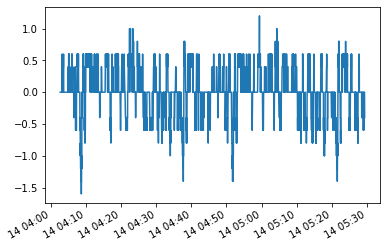

In [10]:
rr_2016["elevation_gain"].plot()

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.



